In [1]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from numpy import dot 
from numpy.linalg import norm
from libpysal.weights.contiguity import Queen
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
from scipy.stats import kurtosis
import os
import copy
import gwpca

mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

# 1. Data Load

In [2]:
data_path = '../data/Dataset' 
os.listdir(data_path)

['fixed_dataset(매출건수).csv',
 'fixed_dataset(자동차유지,10퍼센트절사평균).csv',
 'fixed_dataset(자동차제거,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv',
 'fixed_dataset(자동차제거,매출raw,null유지).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1126).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,버퍼점포밀도,1202).csv',
 'fixed_dataset.csv',
 'fixed_dataset_1105.csv',
 'fixed_dataset_1214.csv']

In [3]:
# 1. 매출 log, null 유지
data = pd.read_csv(os.path.join(data_path,'fixed_dataset_1214.csv'),encoding='euc-kr')

# 2. 자동차제거,매출log,null유지,절사평균
# data = pd.read_csv(os.path.join(data_path,'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv'),encoding='euc-kr')
data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,163.106482,...,1.609438,2.390980,86.099041,2.342449,2.695669,31337.73585,0.268398,0.149563,0.406896,7.046875
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,156.249615,...,1.127535,1.985080,346.978396,2.315147,2.280277,344640.00000,0.254881,0.667946,0.439757,11.523810
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,111.950730,...,2.029155,1.314799,876.110071,2.064957,2.339853,174949.46240,0.220317,0.899425,0.508371,143.584416
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,2.364045,2.064017,232.748015,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,177.329451,...,2.289920,2.379112,2495.942389,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               161 non-null    int64  
 1   BAS_AR               161 non-null    float64
 2   도로길이고려_전체통합도         161 non-null    float64
 3   도로길이고려_국부통합도_R3      161 non-null    float64
 4   기초구역평균_전체통합도         161 non-null    float64
 5   기초구역평균_국부통합도_R3      161 non-null    float64
 6   도로율                  161 non-null    float64
 7   평균 도로 길이             161 non-null    float64
 8   아파트시세변화_차분평균         161 non-null    float64
 9   평균영업기간               158 non-null    float64
 10  평균폐업기간               151 non-null    float64
 11  평균최근접역거리             160 non-null    float64
 12  평균최근접정류장거리           160 non-null    float64
 13  건물노후도                161 non-null    float64
 14  공동주택 비율              161 non-null    float64
 15  근린생활시설 비율            161 non-null    flo

## 1.1 결측치 확인

In [5]:
data.isnull().sum()

BAS_ID                  0
BAS_AR                  0
도로길이고려_전체통합도            0
도로길이고려_국부통합도_R3         0
기초구역평균_전체통합도            0
기초구역평균_국부통합도_R3         0
도로율                     0
평균 도로 길이                0
아파트시세변화_차분평균            0
평균영업기간                  3
평균폐업기간                 10
평균최근접역거리                1
평균최근접정류장거리              1
건물노후도                   0
공동주택 비율                 0
근린생활시설 비율               0
단독주택 비율                 0
아파트 가구수                 0
외식업매출월평균변화량             4
서비스업매출월평균변화량            3
소매업매출월평균변화량             5
외식업매출비율                 8
서비스업매출비율                5
소매업매출비율                 5
외식업종다양성                 1
서비스업종다양성                1
소매업종다양성                 1
상가밀도                    1
주중 / 주말                 0
06 to 18 / 18 to 06     0
개별공시지가 변화 차분평균          0
(주거인구+직장인구) / 유동인구      0
주거인구/직장인구               0
10_30 / 40_60           0
점포밀도                    1
dtype: int64

### 1.1.1 평균운영기간, 평균폐업기간
- 영업기간, 폐업기간 둘 다 없을 경우 제거
- 영업기간은 있지만 폐업기간이 없을 경우 영업기간으로 대체
- 점포밀도가 무한대인 row 제거

In [6]:
data[data['평균폐업기간'].isnull()][['BAS_ID','평균영업기간','평균폐업기간','점포밀도']]

,BAS_ID,평균영업기간,평균폐업기간,점포밀도
22,21322,201.466149,NaN,2.666667
27,21327,89.858108,NaN,12.000000
39,21339,82.104355,NaN,0.000000
72,21372,NaN,NaN,28.500000
73,21373,252.747147,NaN,26.633333
75,21375,NaN,NaN,2.000000
81,21381,183.029083,NaN,16.920000
86,21386,132.306618,NaN,10.750000
159,21459,165.177930,NaN,2.666667
160,21460,NaN,NaN,NaN


In [7]:
# 제거할 row 정의 및 제거

drop_index = list(data[data['평균영업기간'].isnull()].index)

clean_data = data.drop(drop_index,axis=0).reset_index(drop=True)

In [8]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               158 non-null    int64  
 1   BAS_AR               158 non-null    float64
 2   도로길이고려_전체통합도         158 non-null    float64
 3   도로길이고려_국부통합도_R3      158 non-null    float64
 4   기초구역평균_전체통합도         158 non-null    float64
 5   기초구역평균_국부통합도_R3      158 non-null    float64
 6   도로율                  158 non-null    float64
 7   평균 도로 길이             158 non-null    float64
 8   아파트시세변화_차분평균         158 non-null    float64
 9   평균영업기간               158 non-null    float64
 10  평균폐업기간               151 non-null    float64
 11  평균최근접역거리             158 non-null    float64
 12  평균최근접정류장거리           158 non-null    float64
 13  건물노후도                158 non-null    float64
 14  공동주택 비율              158 non-null    float64
 15  근린생활시설 비율            158 non-null    flo

In [9]:
# 평균폐업기간 null값 평균영업기간으로 대체

null_data_index = list(clean_data[clean_data['평균폐업기간'].isnull()].index)

for idx in null_data_index:
    clean_data.iloc[idx,10] = clean_data.iloc[idx,9]

In [10]:
condition = clean_data['외식업매출월평균변화량'].isnull() | clean_data['소매업매출월평균변화량'].isnull() 
clean_data[condition].loc[:,['BAS_ID','외식업매출월평균변화량','서비스업매출월평균변화량','소매업매출월평균변화량']]

,BAS_ID,외식업매출월평균변화량,서비스업매출월평균변화량,소매업매출월평균변화량
27,21327,-34481.37931,NaN,NaN
39,21339,-63057.75862,-2.931084e+07,NaN
72,21373,NaN,1.759062e+05,276226.6034
84,21386,-633171.81030,NaN,NaN
109,21411,NaN,-2.047334e+04,-423603.6429


In [11]:
clean_data.fillna(0,inplace=True)

In [12]:
# null값은 없다.
clean_data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
아파트시세변화_차분평균           0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
건물노후도                  0
공동주택 비율                0
근린생활시설 비율              0
단독주택 비율                0
아파트 가구수                0
외식업매출월평균변화량            0
서비스업매출월평균변화량           0
소매업매출월평균변화량            0
외식업매출비율                0
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말                0
06 to 18 / 18 to 06    0
개별공시지가 변화 차분평균         0
(주거인구+직장인구) / 유동인구     0
주거인구/직장인구              0
10_30 / 40_60          0
점포밀도                   0
dtype: int64

## 1.2 geometry 정보 로딩

In [13]:
basis_area= gpd.read_file('../data/전처리 파일/부평구_기초구역_5181/부평구_기초구역_4326.shp')
basis_area.head()

,BAS_AR,BAS_ID,BAS_MGT_SN,CTP_KOR_NM,MVMN_DE,MVMN_RESN,NTFC_DE,OPERT_DE,SIG_CD,SIG_KOR_NM,center_x,center_y,geometry
0,2.648838,21459,2823700025,인천광역시,None,None,20121221,None,28237,부평구,126.742914,37.474121,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,0.156212,21384,2823700061,인천광역시,None,None,20121221,None,28237,부평구,126.708049,37.489905,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,0.076024,21403,2823700058,인천광역시,None,None,20121221,None,28237,부평구,126.732706,37.489535,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,0.527205,21447,2823700035,인천광역시,None,None,20121221,None,28237,부평구,126.694834,37.482046,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,0.073898,21421,2823700036,인천광역시,None,None,20121221,None,28237,부평구,126.737058,37.484080,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [14]:
use_basis_area = basis_area[['BAS_ID','geometry']]
use_basis_area

,BAS_ID,geometry
0,21459,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,21384,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,21403,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,21447,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,21421,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."
...,...,...
156,21423,"POLYGON ((126.73624 37.48294, 126.73641 37.482..."
157,21441,"POLYGON ((126.70483 37.48126, 126.70465 37.481..."
158,21446,"POLYGON ((126.70290 37.47138, 126.70289 37.471..."
159,21453,"POLYGON ((126.70070 37.46956, 126.70069 37.469..."


In [15]:
use_basis_area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
clean_data['BAS_ID'] = clean_data['BAS_ID'].astype(str) # string 티입으로 변환
clean_data = clean_data.merge(use_basis_area,how='left',right_on='BAS_ID',left_on='BAS_ID').sort_values(by='BAS_ID')
clean_data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도,geometry
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,163.106482,...,2.390980,86.099041,2.342449,2.695669,31337.73585,0.268398,0.149563,0.406896,7.046875,"POLYGON ((126.69032 37.52345, 126.69084 37.523..."
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,156.249615,...,1.985080,346.978396,2.315147,2.280277,344640.00000,0.254881,0.667946,0.439757,11.523810,"POLYGON ((126.69791 37.52246, 126.69791 37.522..."
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,111.950730,...,1.314799,876.110071,2.064957,2.339853,174949.46240,0.220317,0.899425,0.508371,143.584416,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,2.064017,232.748015,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,177.329451,...,2.379112,2495.942389,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."


In [17]:
center = gpd.GeoDataFrame(clean_data).centroid

clean_data['x'] = center.x
clean_data['y'] = center.y

clean_data.iloc[:,-3:]

,geometry,x,y
0,"POLYGON ((126.69032 37.52345, 126.69084 37.523...",126.689135,37.518708
1,"POLYGON ((126.69791 37.52246, 126.69791 37.522...",126.695459,37.522417
2,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.701342,37.522339
3,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
4,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.703419,37.519319
...,...,...,...
153,"POLYGON ((126.69459 37.47098, 126.69442 37.470...",126.692372,37.471208
154,"POLYGON ((126.72120 37.48069, 126.72130 37.480...",126.723687,37.476074
155,"POLYGON ((126.75185 37.48111, 126.75174 37.480...",126.749377,37.478546
156,"POLYGON ((126.73533 37.48512, 126.73537 37.485...",126.731154,37.483105


## 1.3 데이터 분포 확인

In [29]:
ind_var = clean_data.drop([col for col in list(clean_data) if '변화' in col],axis=1)
ind_var = ind_var.drop(['BAS_ID','BAS_AR','x','y','건물노후도','geometry','평균영업기간','평균폐업기간'],axis=1)

In [30]:
ind_var.columns

Index(['도로길이고려_전체통합도', '도로길이고려_국부통합도_R3', '기초구역평균_전체통합도', '기초구역평균_국부통합도_R3',
       '도로율', '평균 도로 길이', '평균최근접역거리', '평균최근접정류장거리', '공동주택 비율', '근린생활시설 비율',
       '단독주택 비율', '아파트 가구수', '외식업매출비율', '서비스업매출비율', '소매업매출비율', '외식업종다양성',
       '서비스업종다양성', '소매업종다양성', '상가밀도', '주중 / 주말', '06 to 18 / 18 to 06',
       '(주거인구+직장인구) / 유동인구', '주거인구/직장인구', '10_30 / 40_60', '점포밀도'],
      dtype='object')

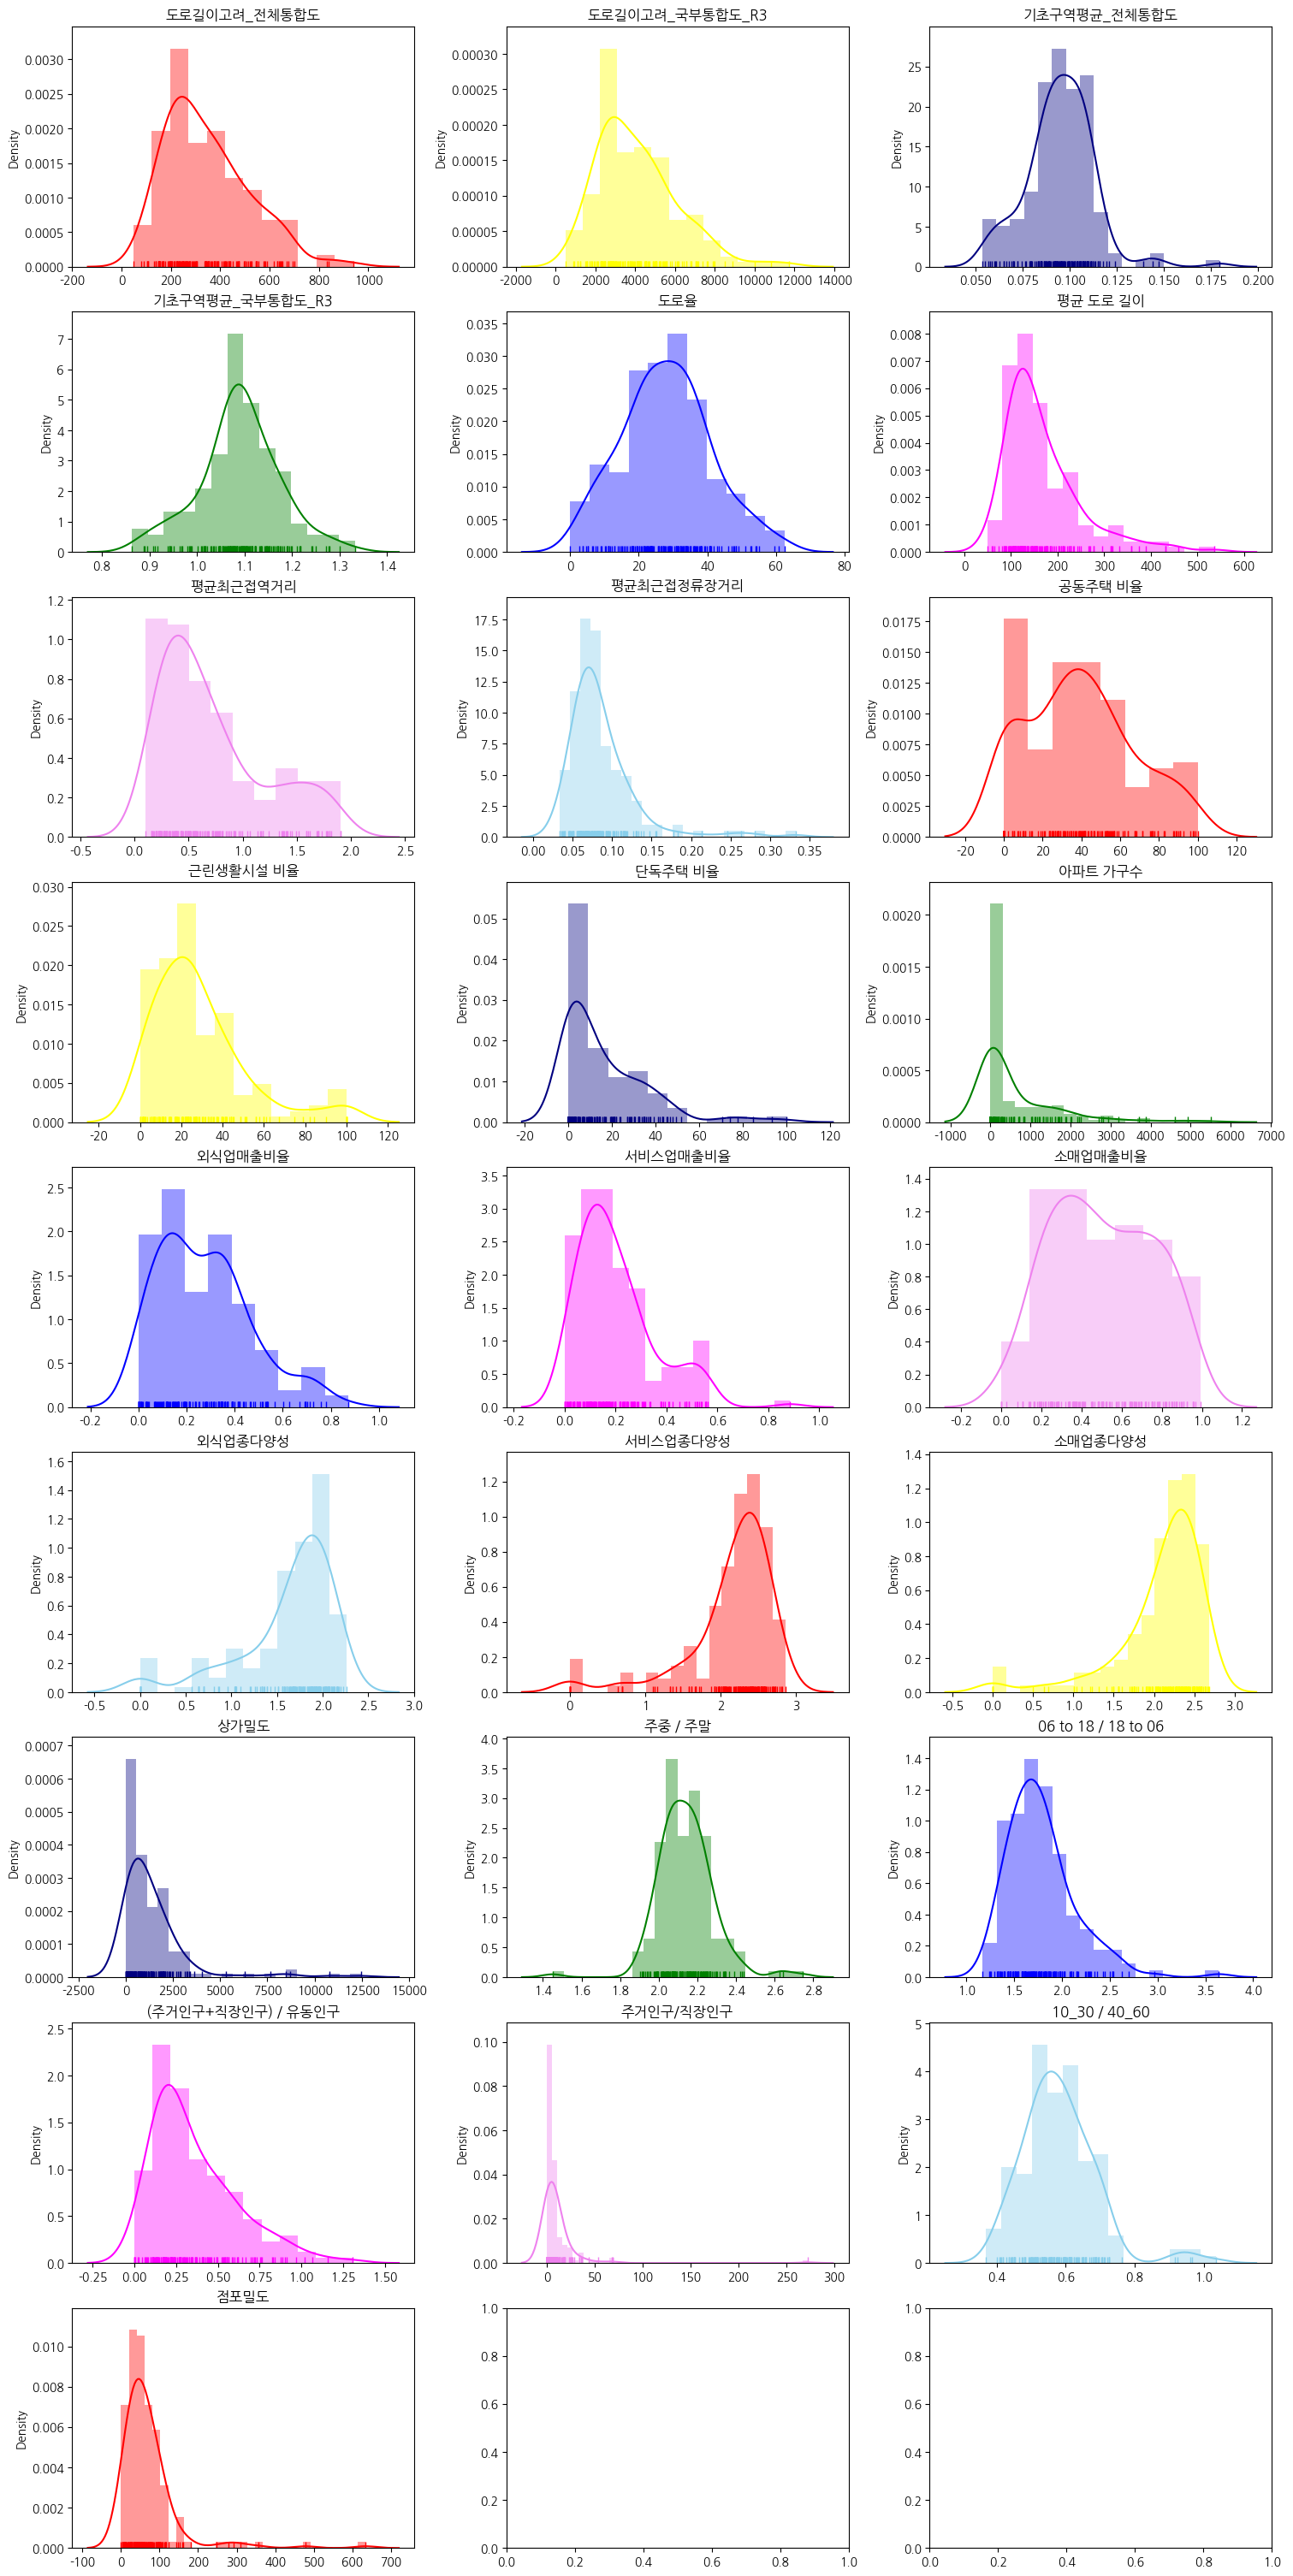

In [32]:
col_list = list(ind_var)
nrows = int(len(col_list)/3)+1
ncols = 3

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,30),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(nrows):
    for j in range(ncols):
        if (ncols*i+j) == len(col_list):
            break
        
        sns.distplot(ax=axes[i,j], x=ind_var[col_list[(ncols*i+j)]], kde=True,color=color[(ncols*i+j) % len(color)],rug=True)
        axes[i,j].set_title(col_list[ncols*i+j])
         
plt.show()

# 2. 공간상관성 검증
- H0 : 군집이 존재하지 않는다. 즉, 모든 구역이 Randomness를 가진다.(AutoCorrelation이 없다.)
- 유의 수준 : 0.05
- 검정통계량 : Morans'I

In [37]:

gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = clean_data.loc[:,'평균영업기간']
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=9999)
moran.I

0.21401617344368642

- HH : the high value area is surrounded by high value
- LH : the low value area is surrounded by high value
- HL : the high value area is surrounded by low value
- LL : the low value area is surrounded by low vlaue

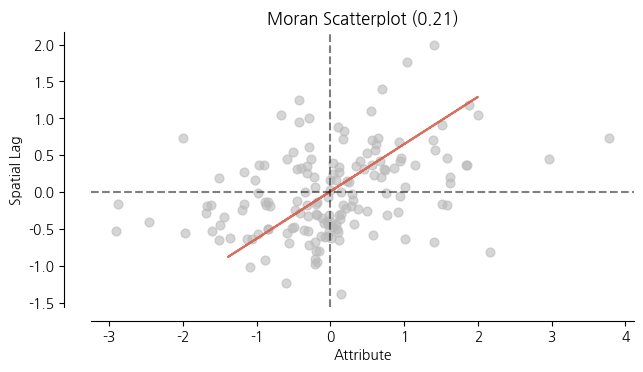

In [34]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

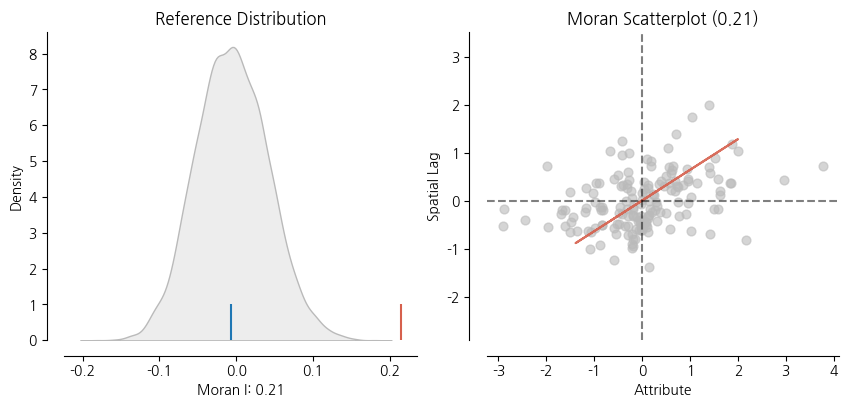

In [35]:
from splot.esda import plot_moran
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [36]:
print('{:.5f}'.format(moran.p_sim))

0.00010


- p-value가 위와 같으므로 유의수준 5%이내에서 전역적으로 보았을 때 군집이 존재하다고 이야기 할수 있다.

## 2.1 독립변수별 Moran's I 검정

In [39]:
spatial_corr = []

for col in list(ind_var):
    temp_y = clean_data.loc[:,col]
    temp_w = Queen.from_dataframe(gdf)

    moran = Moran(temp_y, temp_w,permutations=999)
    print('='*30)
    print('column : '+col)
    print('Moran\'s I : {:5f}'.format(moran.I))
    print('p-value : {:.5f}'.format(moran.p_sim))
    if moran.p_sim < 0.05:
        spatial_corr.append(col)

column : 도로길이고려_전체통합도
Moran's I : 0.234753
p-value : 0.00100
column : 도로길이고려_국부통합도_R3
Moran's I : 0.182845
p-value : 0.00100
column : 기초구역평균_전체통합도
Moran's I : 0.601437
p-value : 0.00100
column : 기초구역평균_국부통합도_R3
Moran's I : 0.299343
p-value : 0.00100
column : 도로율
Moran's I : 0.348744
p-value : 0.00100
column : 평균 도로 길이
Moran's I : 0.288611
p-value : 0.00100
column : 평균최근접역거리
Moran's I : 0.816061
p-value : 0.00100
column : 평균최근접정류장거리
Moran's I : 0.246417
p-value : 0.00100
column : 공동주택 비율
Moran's I : 0.035579
p-value : 0.16900
column : 근린생활시설 비율
Moran's I : 0.030809
p-value : 0.19200
column : 단독주택 비율
Moran's I : 0.225895
p-value : 0.00100
column : 아파트 가구수
Moran's I : 0.311932
p-value : 0.00100
column : 외식업매출비율
Moran's I : 0.012578
p-value : 0.35900
column : 서비스업매출비율
Moran's I : 0.092193
p-value : 0.02500
column : 소매업매출비율
Moran's I : 0.098814
p-value : 0.01600
column : 외식업종다양성
Moran's I : 0.141365
p-value : 0.00400
column : 서비스업종다양성
Moran's I : 0.172464
p-value : 0.00300
column : 소매업종다양성


# 3. LISA 검정
- 왜 국지적 모델(GWR)을 써야하는가?
- Morans'I를 통해서 공간적 의존성은 확인할 수 있으나 공간적 이질성은 확인할 수가 없다.
- 공간적 의존성 : 공간상의 한 지점에서 측정된 현상이 다른 지점에서의 측정값과 서로 관련이 있을 때 나타난다.
- 공간적 이질성 : 각 지점이나 지역에 내재된 고유성에서 발생하게 되는 자료의 지리적 변이나 통계적 특성의 차이를 말한다.
- LISA 검정을 통해서 공간적 이질성이 존재하는지 확인해본다.
- H0 : 특정지역별로 공간적 군집이 형성되지 않는다.
- 유의 수준 : 0.05

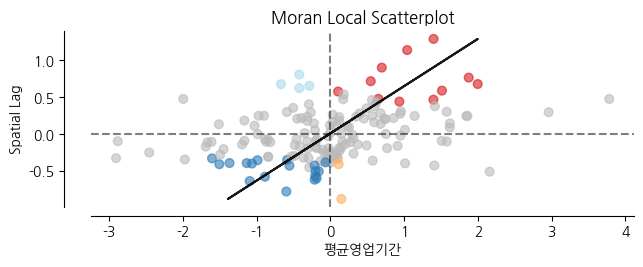

In [42]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisa = Moran_Local(y, w)
fig, ax = moran_scatterplot(lisa, p=0.05,aspect_equal = True)
ax.set_xlabel('평균영업기간')
ax.set_ylabel('Spatial Lag')
plt.show()

In [43]:
lisa.sim.shape
# 158개 row를 999번 시행하여 값 생성

(999, 158)

In [44]:
sig = lisa.p_sim < 0.05
sig.sum()

36

In [45]:
hotspots = lisa.q==1 * sig
hotspots.sum()

11

In [46]:
# HH Area
clean_data[hotspots]

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도,geometry,x,y
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.50000,153.728003,...,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.23100,177.329451,...,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.703419,37.519319
8,21308,0.229900,421.903482,5071.581658,0.093441,1.153545,9.134493,156.407455,0.00000,196.324360,...,2.262532,1.770196,67064.35185,0.970011,9.507922,0.511661,21.785714,"POLYGON ((126.69275 37.51095, 126.69369 37.510...",126.694636,37.509724
9,21309,0.102131,342.128741,4248.872704,0.098518,1.144899,33.748921,149.365524,1716.71400,136.442782,...,2.146131,1.985019,77593.49776,0.242858,4.188744,0.474761,111.666667,"POLYGON ((126.70394 37.51300, 126.70393 37.512...",126.702572,37.510880
67,21367,0.228448,433.242790,5042.136816,0.094212,1.099477,23.912363,125.875000,168.32500,177.378043,...,2.244106,1.861148,86329.74684,1.018047,26.379078,0.518825,18.473684,"POLYGON ((126.69990 37.50892, 126.69990 37.508...",126.696109,37.507611
68,21368,0.218311,302.074763,3370.850035,0.088329,1.013514,5.180353,79.951000,-172.09800,166.065012,...,2.227330,1.885386,98608.75000,0.309573,7.710605,0.509767,39.752577,"POLYGON ((126.69505 37.50601, 126.69556 37.505...",126.692740,37.505831
71,21371,0.276454,254.133267,2766.003388,0.086290,0.941897,11.016673,171.059500,116.79080,155.173618,...,2.217672,1.762641,52661.15702,0.318259,5.566451,0.536672,55.027027,"POLYGON ((126.69948 37.50457, 126.69952 37.504...",126.695205,37.502867
73,21374,0.198816,140.136070,1592.683469,0.079993,0.963076,2.672857,114.440600,268.75000,192.460924,...,2.058284,1.719360,46578.12500,0.553758,13.475751,0.594772,8.473684,"POLYGON ((126.70348 37.49056, 126.70347 37.490...",126.700270,37.488368
150,21452,0.129221,295.107237,5360.472849,0.062597,1.132722,28.532852,101.279475,169.95825,162.713991,...,2.068640,1.519911,54042.11356,0.297824,2.868343,0.529060,123.867435,"POLYGON ((126.69925 37.47367, 126.69931 37.473...",126.699041,37.471886
151,21453,0.093812,268.735857,5016.309188,0.059687,1.106535,32.940048,88.919194,0.00000,150.442216,...,2.173057,1.837254,47000.36496,0.231797,2.553879,0.472402,73.131579,"POLYGON ((126.70070 37.46956, 126.70069 37.469...",126.697506,37.470391


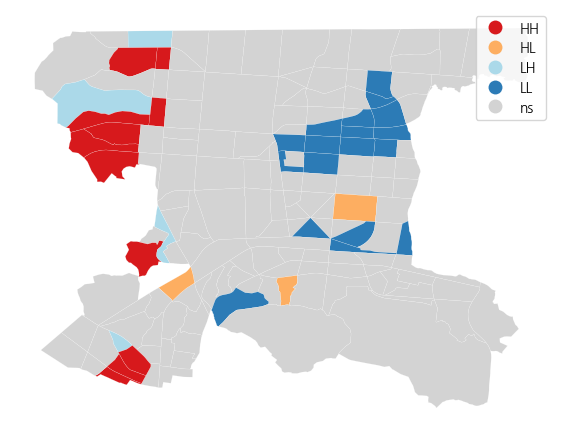

In [47]:
from splot.esda import lisa_cluster

gdf = gpd.GeoDataFrame(gdf)

lisa_cluster(lisa, gdf, p=0.05, figsize = (7,7))
plt.show()

- 총 14곳의 hotspot이 존재한다. 따라서 공간적 이질성을 가진다고 판단할 수 있고, GWR 모델을 고려해야 한다.

# 4. OLS

## 4.1 독립변수, 종속변수 설정

In [48]:
import statsmodels.api as sm

In [50]:
# X = clean_data.iloc[:,ind_var_col]
X = sm.add_constant(ind_var)
y = clean_data.loc[:,'평균영업기간'].values
ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     3.596
Date:                Wed, 29 Dec 2021   Prob (F-statistic):           9.03e-07
Time:                        13:29:52   Log-Likelihood:                -728.98
No. Observations:                 158   AIC:                             1510.
Df Residuals:                     132   BIC:                             1590.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 174.5305     60.065      2.906      0.004      55.715     293.346
도로길이고려_전체통합도            0.0234      0.073      0.319      0.750      -0.122       0.168
도로길이고려_국부통합도_R3        -0.0012      0.006     -0.200      0.842      -0.013       0.011
기초구역평균_전체통합도         -175.0520    299.449     -0.585      0.560    -767.391     417.287
기초구역평균_국부통합도_R3       -75.0444     44.515     -1.686      0.094    -163.100      13.011
도로율                    -0.0407      0.259     -0.157      0.876      -0.554       0.473
평균 도로 길이               -0.0810      0.036     -2.265      0.025      -0.152      -0.010
평균최근접역거리               19.4777      6.071      3.208      0.002       7.468      31.487
평균최근접정류장거리           -124.2848     68.545     -1.813      0.072    -259.874      11.304
공동주택 비율                 0.4203      0.144      2.912      0.004       0.135       0.706
근린생활시설 비율               0.2863      0.132      2.168      0.032       0.025       0.547
단독주택 비율                 0.5883      0.163      3.614      0.000       0.266       0.910
아파트 가구수                -0.0036      0.003     -1.222      0.224      -0.009       0.002
외식업매출비율               -15.6246     25.007     -0.625      0.533     -65.091      33.841
서비스업매출비율                2.3509     24.841      0.095      0.925     -46.787      51.488
소매업매출비율               -16.8685     22.467     -0.751      0.454     -61.310      27.573
외식업종다양성               -10.6954      6.634     -1.612      0.109     -23.817       2.427
서비스업종다양성                8.5058      7.246      1.174      0.243      -5.828      22.839
소매업종다양성                 3.7824      7.972      0.474      0.636     -11.987      19.552
상가밀도                    0.0041      0.003      1.478      0.142      -0.001       0.010
주중 / 주말                16.7527     21.202      0.790      0.431     -25.187      58.693
06 to 18 / 18 to 06     3.6227     10.951      0.331      0.741     -18.039      25.284
(주거인구+직장인구) / 유동인구     12.2551     11.938      1.027      0.307     -11.360      35.871
주거인구/직장인구              -0.1354      0.111     -1.223      0.224      -0.354       0.084
10_30 / 40_60         -20.7444     40.424     -0.513      0.609    -100.707      59.218
점포밀도                   -0.0360      0.062     -0.584      0.560      -0.158       0.086
==============================================================================
Omnibus:                        8.385   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               13.839
Skew:                           0.214   Prob(JB):                     0.000988
Kurtosis:                       4.385   Cond. No.                     6.84e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance ma

## 4.2 Modeling

### 4.2.1 다중공선성

In [52]:
def check_vif(dX):
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(dX.values,i) for i in range(dX.values.shape[1])] 
    vif['features'] = dX.columns
    vif = vif.sort_values("VIF Factor").reset_index(drop=True)
    
    return vif

result = check_vif(ind_var)
result.iloc[-10:,]

,VIF Factor,features
15,35.725738,소매업매출비율
16,56.915752,서비스업종다양성
17,64.561321,소매업종다양성
18,83.430633,06 to 18 / 18 to 06
19,118.302165,10_30 / 40_60
20,167.194070,도로길이고려_국부통합도_R3
21,176.870832,도로길이고려_전체통합도
22,179.053716,기초구역평균_전체통합도
23,334.075718,주중 / 주말
24,424.057135,기초구역평균_국부통합도_R3


#### 4.2.1.2 column 제거

In [54]:
def RFE(df):
    flag = True
    next_col = list(df.columns)
    
    while flag:
        local = df.loc[:,next_col]
        result = check_vif(local)

        if len(result[result['VIF Factor'] > 10]) == 0:
            return result # 유일한 탈출 조건
        
#         display(result[-7:])
        next_col = result.iloc[:-1,1].values.tolist()
        
vif_result = RFE(ind_var)
optimal_feature = vif_result['features'].values.tolist()
optimal_feature

['주거인구/직장인구',
 '아파트 가구수',
 '단독주택 비율',
 '서비스업매출비율',
 '외식업매출비율',
 '근린생활시설 비율',
 '평균최근접역거리',
 '(주거인구+직장인구) / 유동인구',
 '공동주택 비율',
 '평균 도로 길이',
 '도로길이고려_전체통합도',
 '평균최근접정류장거리',
 '점포밀도',
 '도로율',
 '상가밀도']

#### 4.2.1.3 Remodeling


In [55]:
X = clean_data.loc[:,optimal_feature].values
X = sm.add_constant(X)
y = clean_data.loc[:,'평균영업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     4.822
Date:                Wed, 29 Dec 2021   Prob (F-statistic):           1.68e-07
Time:                        13:31:09   Log-Likelihood:                -737.49
No. Observations:                 158   AIC:                             1507.
Df Residuals:                     142   BIC:                             1556.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.9694     17.021      6.343      0.000      74.323     141.616
x1            -0.0966      0.107     -0.901      0.369      -0.308       0.115
x2            -0.0051      0.003     -1.870      0.064      -0.010       0.000
x3             0.5975      0.149      4.003      0.000       0.302       0.893
x4            13.9741     15.040      0.929      0.354     -15.757      43.705
x5            -7.1313     12.026     -0.593      0.554     -30.905      16.643
x6             0.2573      0.126      2.047      0.043       0.009       0.506
x7            21.7951      5.223      4.173      0.000      11.471      32.119
x8            11.2299     11.051      1.016      0.311     -10.615      33.075
x9             0.4299      0.133      3.227      0.002       0.167       0.693
x10           -0.0687      0.032     -2.163      0.032      -0.132      -0.006
x11            0.0010      0.014      0.073      0.942      -0.027       0.029
x12         -120.0455     62.112     -1.933      0.055    -242.829       2.738
x13           -0.0355      0.057     -0.618      0.538      -0.149       0.078
x14           -0.1725      0.241     -0.716      0.475      -0.649       0.304
x15            0.0024      0.003      0.893      0.373      -0.003       0.008
==============================================================================
Omnibus:                        4.615   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                5.700
Skew:                           0.134   Prob(JB):                       0.0578
Kurtosis:                       3.891   Cond. No.                     6.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.2.2 잔차분석
- 회귀모형에 대한 가정(정규성, 등분산성, 독립성)을 충족하는지에 대한 검정, 이상치가 개입하는지에 대한 검정을 하는 절차

In [56]:
import scipy as sp
from scipy import stats

#### 4.2.2.1 잔차 정규성

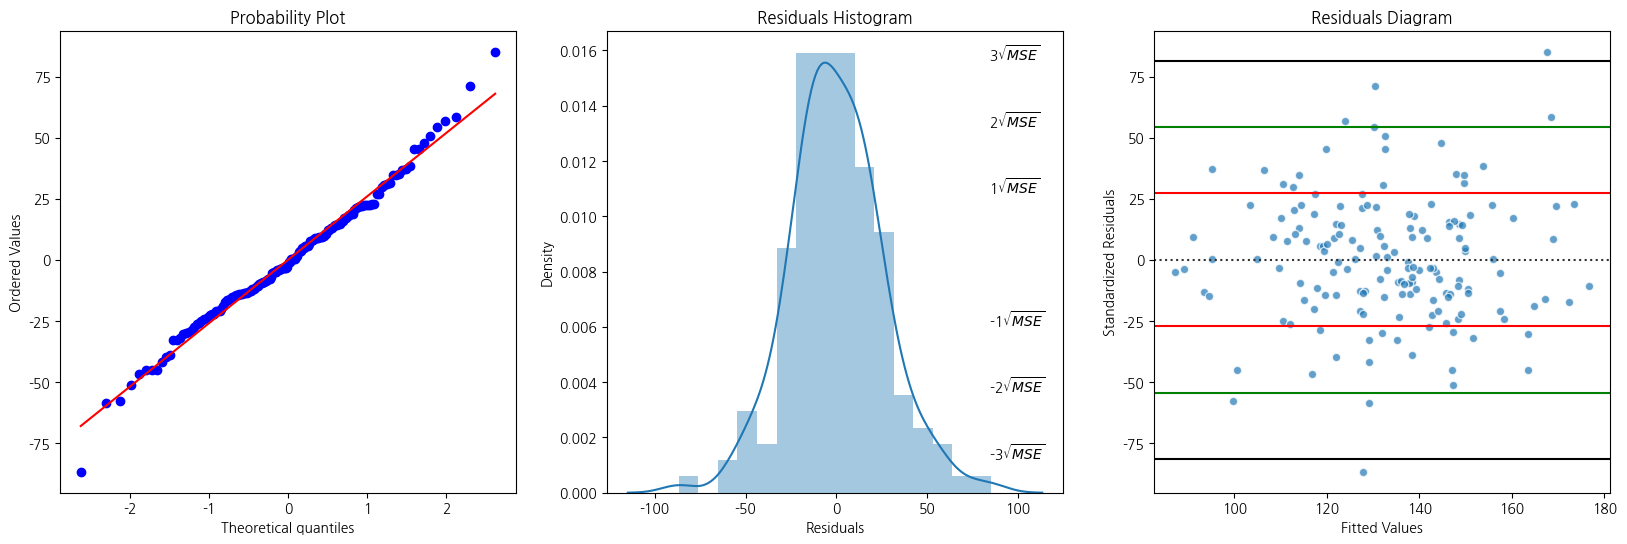

In [57]:
figure, axs = plt.subplots(1,3, figsize = (20,6))

# 잔차 Q-Q  plot
# sm.ProbPlot(fit1.resid).qqplot(line="s",ax=axs[0])
sp.stats.probplot(results.resid, dist='norm', fit=True, plot=axs[0])

# 잔차의 히스토그램
sns.distplot(x = results.resid , ax = axs[1])
axs[1].set_xlabel("Residuals")
axs[1].set_title("Residuals Histogram")

# 잔차도 MSE 라인
yhat = pd.DataFrame(results.fittedvalues)
temp = pd.concat([yhat,clean_data.loc[:,'평균영업기간']],axis=1)
temp.columns = ['yhat','MEDV']

sns.residplot(x='yhat',y='MEDV',data=temp, scatter_kws = {'edgecolor':"white", "alpha":0.7}, line_kws = {"color":"red"})
MSE_sq = np.sqrt(results.mse_resid) #RMSE

# 잔차도 MSE line
for i, c in enumerate(["red", "green", "black"]):
    axs[2].axhline( (i+1) * MSE_sq, color = c)
    axs[2].axhline( -(i+1) * MSE_sq, color = c)
    
    axs[2].text(47, (i+1) * MSE_sq, f"{i+1}"r'${}\sqrt{MSE}$')
    axs[2].text(47, -(i+1) * MSE_sq, f"-{i+1}"r'${}\sqrt{MSE}$')

axs[2].set_xlabel("Fitted Values")
axs[2].set_ylabel("Standardized Residuals")
axs[2].set_title("Residuals Diagram")

plt.show()

In [58]:
test = stats.shapiro(results.resid)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 귀무가설을 기각할 수 없으므로 정규성을 따른다.

검정통계량 : 0.9899196028709412
p-value : 0.32134881615638733


#### 4.2.2.2 잔차 등분산성
- 종속 변수의 값의 분산이 독립 변수의 값과 상관없이 고정된 값을 가져야 한다.
- 실제 데이터는 독립 변수 값의 크기가 커지면 종속 변수 값의 분산도 커지는 이분산성 문제가 발생한다.

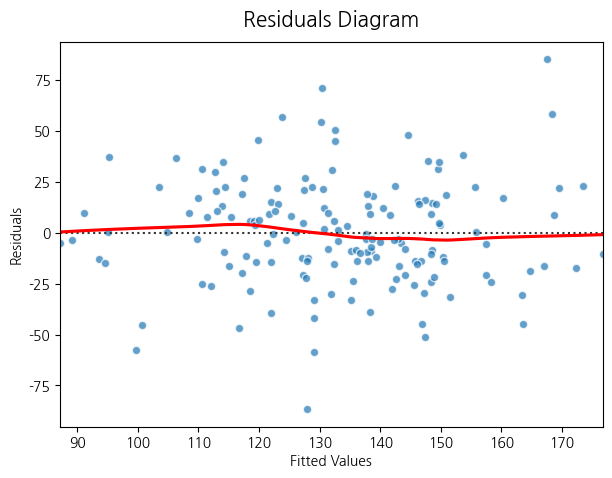

In [59]:
fig = plt.figure(figsize= (7,5))

p = sns.residplot(x = "yhat", y = "MEDV", 
                  data = temp, 
                  scatter_kws = {'edgecolor':"white", "alpha":0.7},
                  lowess = True,
              line_kws = {"color":"red"})

p.set_title("Residuals Diagram", fontsize=15, y=1.02)
p.set(xlabel= "Fitted Values", ylabel = "Residuals")

plt.show()

In [60]:
from sklearn.linear_model import LinearRegression
from scipy.stats import chisqprob


def breusch_pagan_test(x, y):
    '''
    Breusch-Pagan test for heteroskedasticity in a linear regression model:
    H_0 = No heteroskedasticity.
    H_1 = Heteroskedasticity is present.

    Inputs:
    x = a numpy.ndarray containing the predictor variables. Shape = (nSamples, nPredictors).
    y = a 1D numpy.ndarray containing the response variable. Shape = (nSamples, ).

    Outputs a list containing three elements:
    1. the Breusch-Pagan test statistic.
    2. the p-value for the test.
    3. the test result.
    '''

    if y.ndim != 1:
        raise SystemExit('Error: y has more than 1 dimension.')
    if x.shape[0] != y.shape[0]:
        raise SystemExit('Error: the number of samples differs between x and y.')
    else:
        n_samples = y.shape[0]

    # fit an OLS linear model to y using x:
    lm = LinearRegression()
    lm.fit(x, y)

    # calculate the squared errors:
    err = (y - lm.predict(x))**2

    # fit an auxiliary regression to the squared errors:
    # why?: to estimate the variance in err explained by x
    lm.fit(x, err)
    pred_err = lm.predict(x)
    del lm

    # calculate the coefficient of determination:
    ss_tot = sum((err - np.mean(err))**2)
    ss_res = sum((err - pred_err)**2)
    r2 = 1 - (ss_res / ss_tot)
    del err, pred_err, ss_res, ss_tot

    # calculate the Lagrange multiplier:
    LM = n_samples * r2
    del r2

    # calculate p-value. degrees of freedom = number of predictors.
    # this is equivalent to (p - 1) parameter restrictions in Wikipedia entry.
    pval = chisqprob(LM, x.shape[1])

    if pval < 0.01:
        test_result = 'Heteroskedasticity present at 99% CI.'
    elif pval < 0.05:
        test_result = 'Heteroskedasticity present at 95% CI.'
    else:
        test_result = 'No significant heteroskedasticity.'
    return [LM, pval, test_result]

tX = clean_data.loc[:,optimal_feature]
ty = clean_data.loc[:,'평균영업기간']

result = breusch_pagan_test(tX,ty)
print('LM : {}\np-value : {}\ntest_result {}'.format(result[0],result[1],result[2]))

# p-value가 유의수준 0.05보다 크므로 귀무가설을 기각할 수 없다. 따라서 등분산성을 만족한다고 할수 있다.

LM : 13.837215028877845
p-value : 0.5379092928451157
test_result No significant heteroskedasticity.


#### 4.2.2.3 잔차 독립성

In [61]:
from statsmodels.stats.stattools import durbin_watson

print(f"D-W 통계량: {round(durbin_watson(results.resid),3)}")

# 통계량이 1.5~2.5 사이이므로 잔차들이 자기상관성을 가지고 있지 않다. 따라서 독립성을 만족한다.

D-W 통계량: 1.788


#### 4.2.2.4 잔차 Moran's I

In [63]:
gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = results.resid
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=9999)
moran.I

0.11371543710701387

In [64]:
print('{:.5f}'.format(moran.p_sim))

0.00860


### 4.2.3 PCA

In [67]:
# Scaling
dX_scaled = StandardScaler().fit_transform(ind_var.values)
std_df = pd.DataFrame(dX_scaled, index=ind_var.index, columns=ind_var.columns)

# PCA
pca = PCA(n_components=len(ind_var.columns))
pca_array = pca.fit_transform(std_df)
pca_df = pd.DataFrame(pca_array, index=ind_var.index,
                      columns=[f"pca{num+1}" for num in range(ind_var.shape[1])])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25
0,-3.535992,-1.870192,-3.494044,0.353180,-1.030196,-0.436724,1.176680,1.561027,-0.422428,1.030584,...,-0.743141,0.506192,0.719634,-0.572398,-0.242960,-0.451330,0.097432,-0.096845,0.157902,-0.108576
1,-3.529532,-0.438488,-0.641512,0.091832,-1.957152,-0.592202,-0.198619,0.687129,-0.772873,0.077956,...,-0.259055,0.189287,-0.765454,-0.043821,-1.246207,0.104638,0.230972,-0.001715,-0.124712,0.012410
2,-1.107534,-0.603615,-0.575973,1.098314,-0.707397,-1.119165,-0.366640,0.016119,-0.605366,-0.563596,...,1.044396,0.296133,0.295862,0.760637,1.342602,0.626406,0.675158,0.675971,-0.285484,-0.027519
3,-1.341933,-2.387545,-2.132626,0.284979,0.670111,1.792976,-0.393077,0.629469,-0.229997,0.114101,...,-0.664386,0.808280,-1.090667,-0.419365,0.652059,0.445145,-0.579754,-0.221881,0.341390,0.041686
4,0.999360,-1.730944,-0.520623,-0.498583,0.926214,1.174284,-1.991104,-0.364004,-0.926088,-0.760606,...,-0.161864,-0.310150,-0.026403,0.129568,-0.071454,-0.064811,-0.109027,0.150590,0.129946,0.081150


In [69]:
# 고윳값과 누적기여율 계산

result = pd.DataFrame({'고윳값':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(ind_var.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,고윳값,기여율,누적기여율
pca1,4.965448,0.197361,0.197361
pca2,3.145584,0.125027,0.322388
pca3,2.918509,0.116001,0.438389
pca4,1.928599,0.076656,0.515045
pca5,1.797483,0.071444,0.586489
pca6,1.512587,0.060121,0.646610
pca7,1.211599,0.048157,0.694767
pca8,1.078594,0.042871,0.737638
pca9,0.981245,0.039001,0.776639
pca10,0.816428,0.032450,0.809090


In [70]:
# 개별 고윳값 즉, 각 주성분 마다 고윳값이 0.7이상인 주성분들, 누적기여율이 80% 이상이 넘어거지는 지점까지의 
# 주성분들을 기준으로 하여 적절한 주성분 개수를 설정한다. 

condition = (result['고윳값'] >= 0.7) & (result['누적기여율'] >= 0.8)
pca_index = list(result[condition].reset_index().index)

In [72]:
pca_columns = list(ind_var.iloc[:,pca_index].columns)
pca_columns

['도로길이고려_전체통합도']

In [74]:
X = ind_var.loc[:,pca_columns].values

In [75]:
#Calibrate GWR model
# 평균영업기간

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.006
Method:                 Least Squares   F-statistic:                              0.000
Date:                Wed, 29 Dec 2021   Prob (F-statistic):                        1.00
Time:                        13:35:36   Log-Likelihood:                         -737.49
No. Observations:                 158   AIC:                                      1477.
Df Residuals:                     157   BIC:                                      1480.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.611e-16      0.005   1.43e-13      1.000      -0.011       0.011
==============================================================================
Omnibus:                        4.615   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                5.700
Skew:                           0.134   Prob(JB):                       0.0578
Kurtosis:                       3.891   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 5. 지리가중회귀분석(GWR)

## 5.1 독립변수, 종속변수 설정
- 다중공선성을 제거한 독립변수들을 이용한다.

In [82]:
s_y1 = clean_data['평균영업기간'].values.reshape((-1,1)) # 종속변수1
s_y2 = clean_data['평균폐업기간'].values.reshape((-1,1)) # 종속변수2

# 다중공선성 제거
s_X= ind_var.loc[:,optimal_feature].values

# Raw Data
# s_X = clean_data.iloc[:,ind_var_col].values

# 왜도 2이상인 데이터 log변환 후, standard scaling 함
# s_X= ss_scaled_dX.values

# s_X = clean_data.loc[:,['서비스업매출비율', '평균최근접정류장거리', '외식업매출월평균변화량', 'BAS_AR', '서비스업매출월평균변화량',
#         '근린생활시설 비율', '아파트 가구수', '상가밀도', '소매업매출월평균변화량']].values
# ['서비스업매출비율', '평균최근접정류장거리', '외식업매출월평균변화량', 'BAS_AR', '서비스업매출월평균변화량',
#        '근린생활시설 비율', '아파트 가구수', '상가밀도', '소매업매출월평균변화량']

# 왜도 2이상인 데이터 log변환 후, standard scaling, 다중공선성 제거
# s_X= ss_scaled_dX.loc[:,optimal_feature].values

# s_X = rm_avg_X.values

# p-value 0.5 이상 지워보자
# drop_col = [0,1,2,9,10,13,15]
# drop_col = [optimal_feature[i] for i in range(len(optimal_feature)) if i in drop_col]
# s_X= ss_scaled_dX.loc[:,optimal_feature]
# s_X = s_X.drop(drop_col,axis=1).values

    
u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

s_X.shape

(158, 15)

### 5.2.1 상권변화 유형

In [91]:
kind_area = clean_data.copy()

In [96]:
avg_open_period = kind_area['평균영업기간']
avg_close_period = kind_area['평균폐업기간']

# 각 기간의 평균 저장
open_mean = 101
# avg_open_period.median()
close_mean = 51
# avg_close_period.median()

# kind column 생성
kind_area['KIND'] = ''

# HH : 정체형, 창업 진출입시 세심한 주의 상권
HH = clean_data[(open_mean < avg_open_period) & (close_mean < avg_close_period)]
kind_area.loc[(open_mean < avg_open_period) & (close_mean < avg_close_period),'KIND'] = 'HH'

# HL : 상권축소형, 경쟁력 있는 기존 업체 우위 상권
HL = clean_data[(open_mean < avg_open_period) & (close_mean > avg_close_period)]
kind_area.loc[(open_mean < avg_open_period) & (close_mean > avg_close_period),'KIND'] = 'HL'

# LH : 상권확장형, 경쟁력 있는 신규 창업 우위 상권
LH = clean_data[(open_mean > avg_open_period) & (close_mean < avg_close_period)]
kind_area.loc[(open_mean > avg_open_period) & (close_mean < avg_close_period),'KIND'] = 'LH'

# LL : 다이나믹(순환)형, 도시재생 및 신규 개발상권으로 창업 진출입시 세심한 주의 상권
LL = clean_data[(open_mean > avg_open_period) & (close_mean > avg_close_period)]
kind_area.loc[(open_mean > avg_open_period) & (close_mean > avg_close_period),'KIND'] = 'LL'

kind_list = [HH,HL,LH,LL]
title_list = ['HH','HL','LH','LL']

In [97]:
print(('='*15)+' 상권변화 유형별 갯수 '+('='*15))
print('HH : {0}\nHL : {1}\nLH : {2}\nLL : {3}'.format(len(HH),len(HL),len(LH),len(LL)))

=============== 상권변화 유형별 갯수 ===============
HH : 132
HL : 5
LH : 19
LL : 2


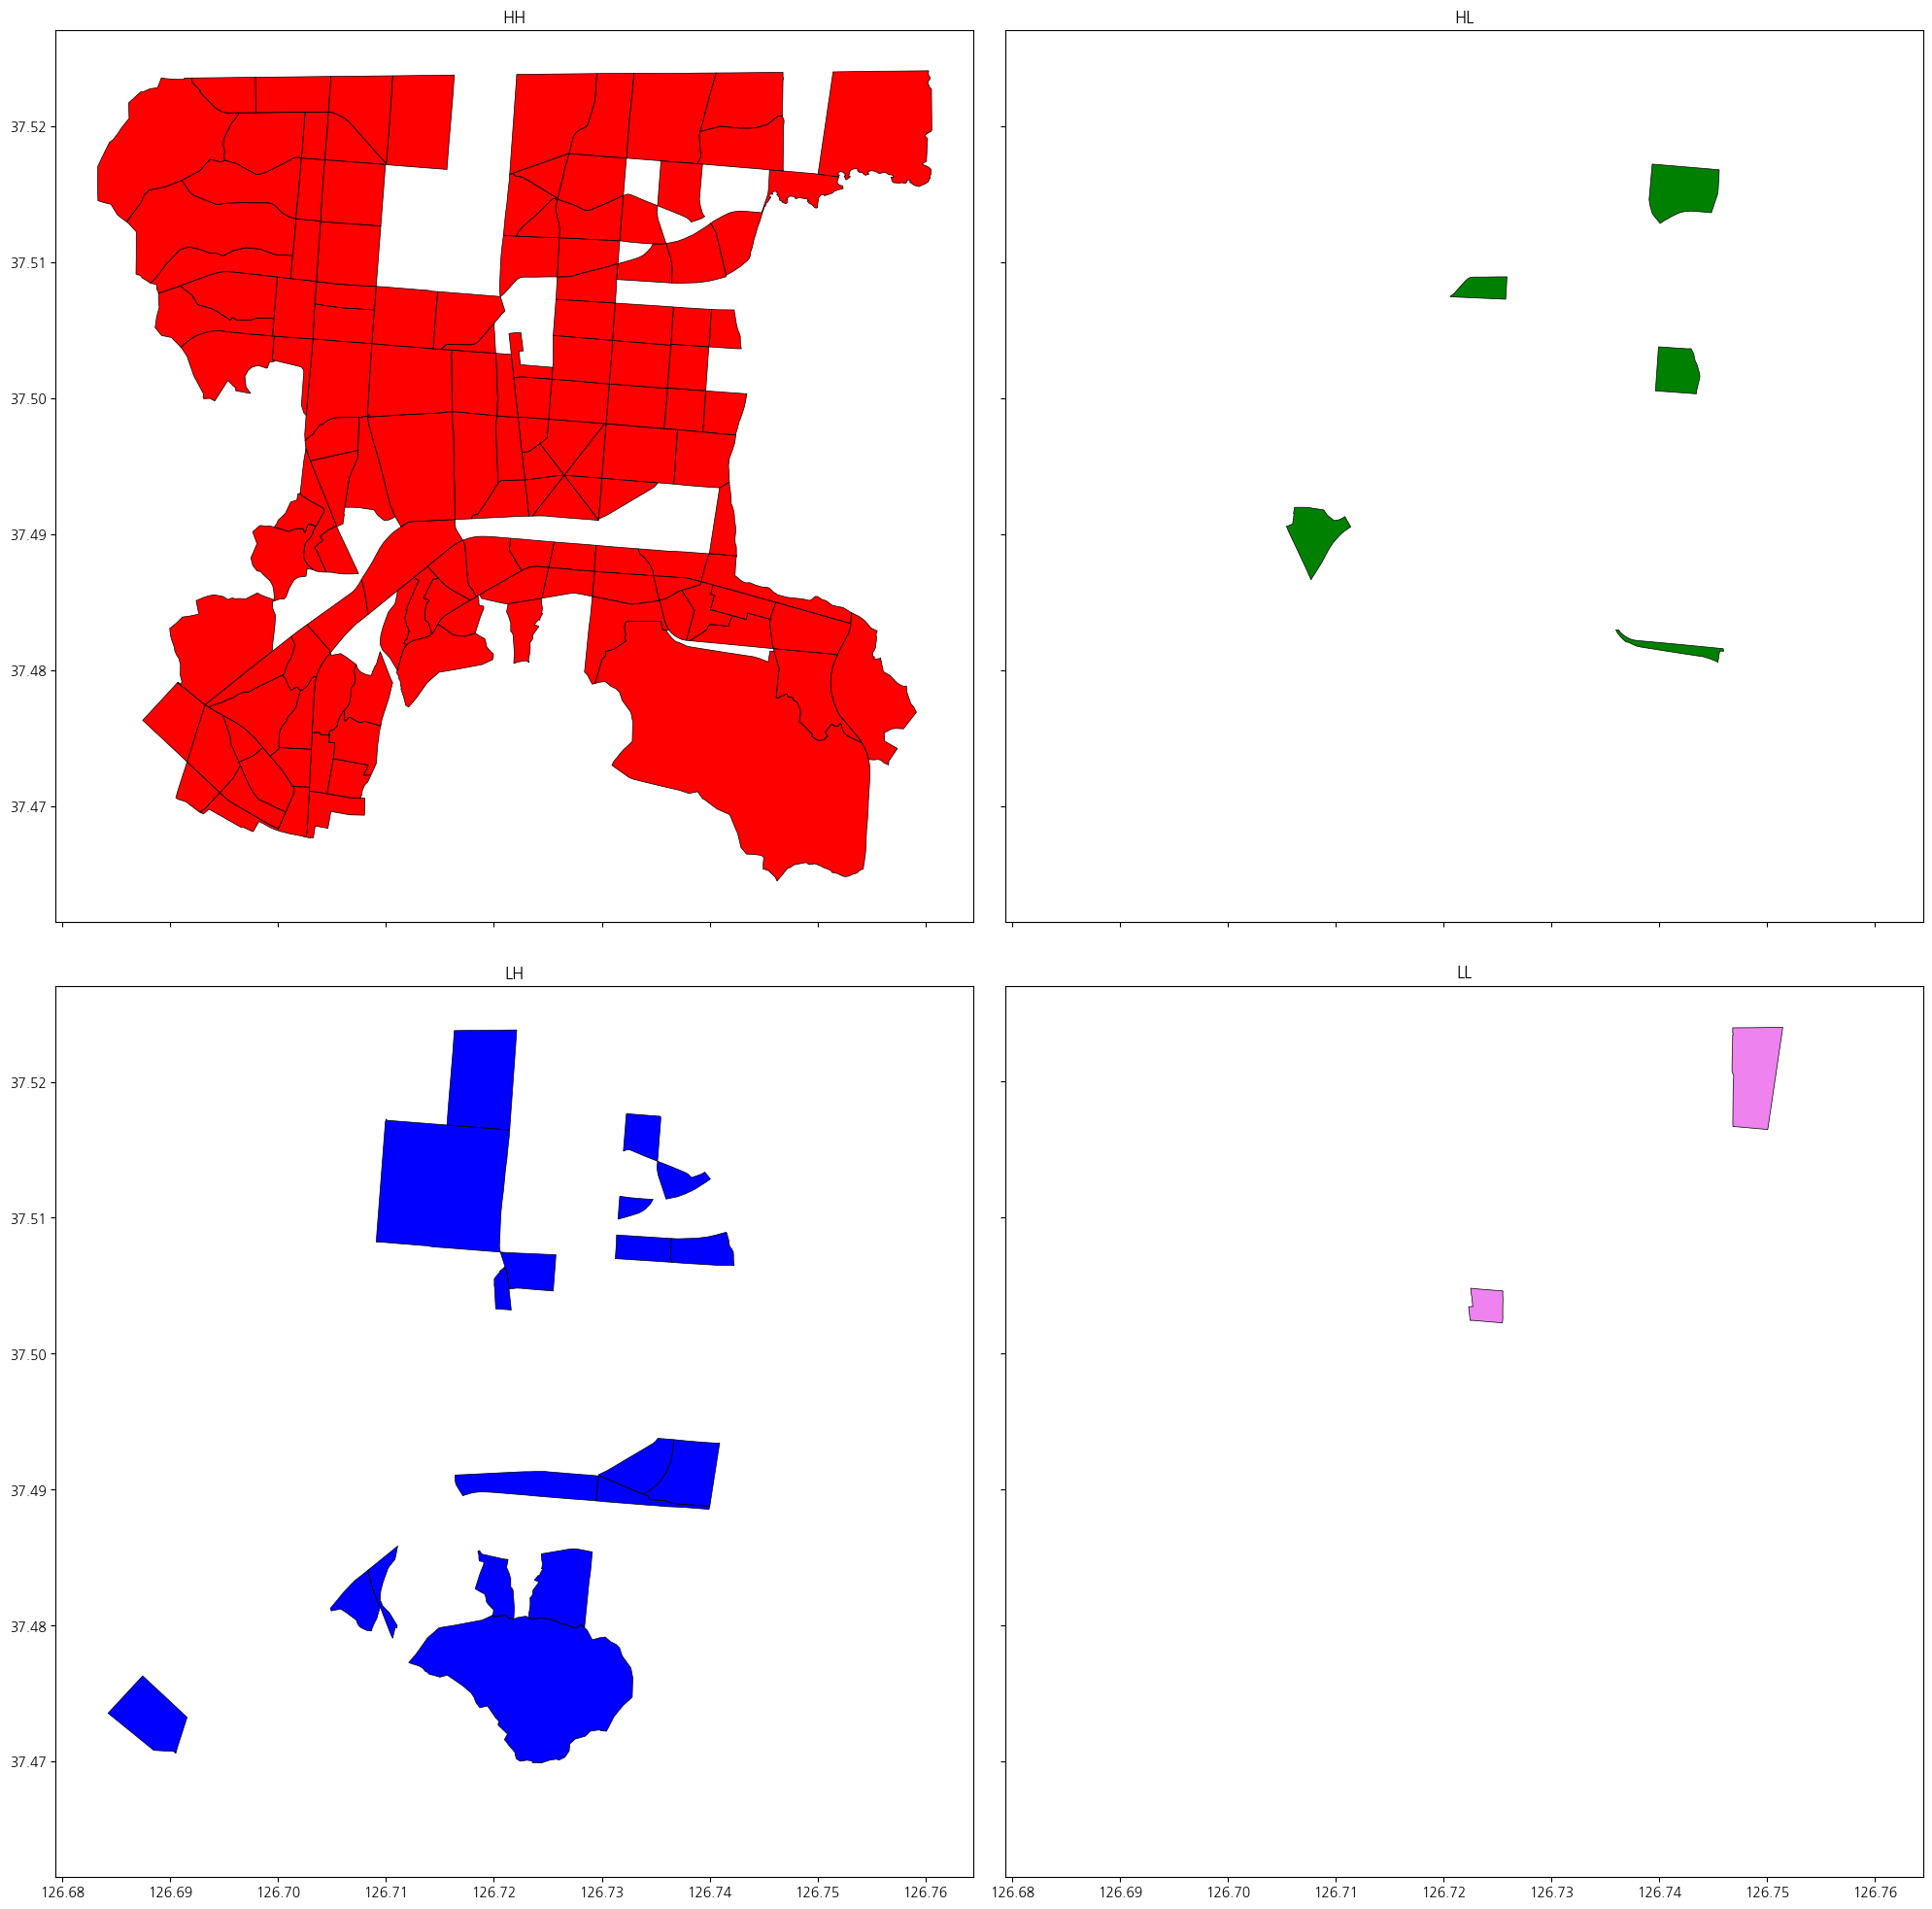

In [98]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(20,20))
colors = ['red','green','blue','violet']
#         HH, HL, LH, LL

for i in range(int(len(kind_list)/2)):
    for j in range(2):
        if len(kind_list[2*i+j]) != 0:          
            gdf = gpd.GeoDataFrame(kind_list[2*i+j])
            gdf.plot(ax=axes[i,j],color=colors[2*i+j])
            gdf.boundary.plot(ax=axes[i,j],color='black',linewidth=0.5)
            axes[i,j].set_title(title_list[2*i+j])

plt.tight_layout()
plt.show()

### 5.2.3 상관관계

#### 5.2.3.1 독립변수와 종속변수간의 상관계수

In [102]:
corr_df = ind_var.loc[:,optimal_feature].copy()
corr_df['평균영업기간'] = clean_data.loc[:,'평균영업기간']
corr_df = corr_df.corr()
ind = corr_df['평균영업기간']
ind[abs(ind) > 0.1]

단독주택 비율               0.341076
평균최근접역거리              0.310831
(주거인구+직장인구) / 유동인구    0.156688
공동주택 비율               0.113177
평균 도로 길이             -0.263731
점포밀도                 -0.144290
상가밀도                 -0.106662
평균영업기간                1.000000
Name: 평균영업기간, dtype: float64

#### 5.2.2.2 상관 그래프

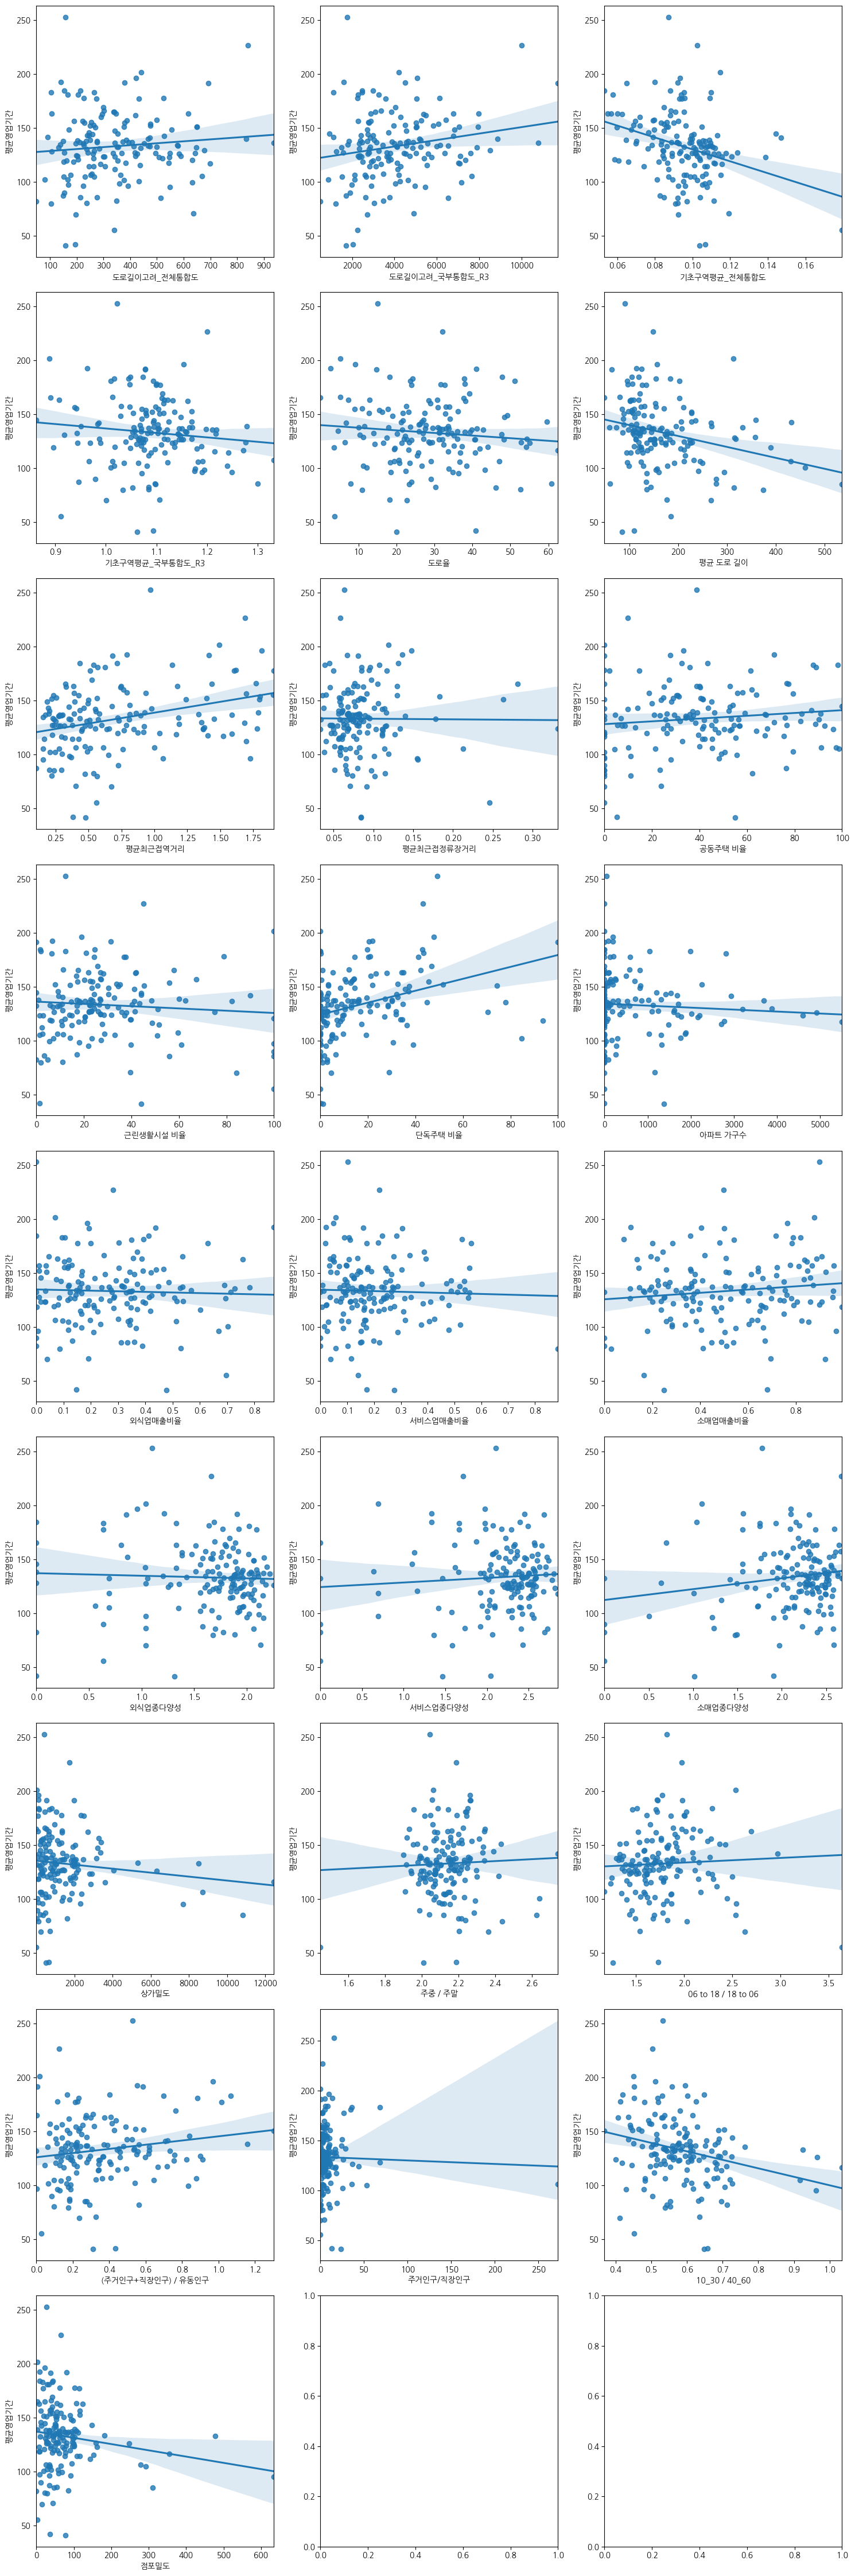

In [106]:
fig, axes = plt.subplots(nrows=int(len(ind_var.columns)/3)+1,ncols=3,figsize=(15,45))

for idx, col in enumerate(ind_var.columns):
    sns.regplot(x=col,y='평균영업기간',data=clean_data,ax=axes[int(idx/3),idx % 3])

plt.tight_layout()
plt.show()

## 5.2 MODELING

In [111]:
#Calibrate GWR model
# 평균영업기간

gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel='f2',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel='f2',spherical=True)
gwr_results = gwr_model.fit()

157.0


In [112]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         104826.347
Log-likelihood:                                                    -737.492
AIC:                                                               1506.984
AICc:                                                              1513.356
BIC:                                                             104107.459
R2:                                                                   0.337
Adj. R2:                                                              0.267

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [114]:
local_con_num = pd.Series(gwr_results.local_collinearity()[2].flatten())

In [115]:
local_con_num.sort_values()

82    26.202787
81    26.222449
79    26.222765
80    26.223703
83    26.229699
        ...    
21    29.766065
26    29.816578
19    30.068613
20    30.262458
22    30.631893
Length: 158, dtype: float64

In [116]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+optimal_feature

In [122]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+optimal_feature
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
# gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균영업기간,bw_110,1110).csv',index=False,encoding='euc-kr')

### 5.2.1 회귀계수를 이용한 각 데이터들 간의 코사인 유사도

In [123]:
from scipy.spatial.distance import cdist
cos_df = pd.DataFrame(cdist(gwr_coef_df.iloc[:,:-3], gwr_coef_df.iloc[:,:-3], metric='cosine'),
                      columns = gwr_coef_df['BAS_ID'],
                      index = gwr_coef_df['BAS_ID'])
cos_df

BAS_ID,21300,21301,21302,21303,21304,21305,21306,21307,21308,21309,...,21450,21451,21452,21453,21454,21455,21456,21457,21458,21459
BAS_ID,,,,,,,,,,,,,,,,,,,,,
21300,1.110223e-16,0.000029,0.000166,0.000152,0.000283,0.000286,0.000155,0.000128,0.000168,0.000327,...,0.003289,0.003453,0.004107,0.004146,0.004115,0.003520,8.692404e-03,0.014053,1.065844e-02,0.012688
21301,2.914133e-05,0.000000,0.000063,0.000064,0.000148,0.000157,0.000077,0.000082,0.000115,0.000202,...,0.003082,0.003218,0.003837,0.003890,0.003874,0.003323,8.094328e-03,0.013164,9.915192e-03,0.011882
21302,1.664613e-04,0.000063,0.000000,0.000006,0.000019,0.000027,0.000018,0.000052,0.000065,0.000058,...,0.002495,0.002592,0.003132,0.003196,0.003196,0.002730,6.851190e-03,0.011476,8.476920e-03,0.010304
21303,1.519582e-04,0.000064,0.000006,0.000000,0.000021,0.000022,0.000004,0.000024,0.000032,0.000043,...,0.002349,0.002452,0.002985,0.003042,0.003038,0.002574,6.731342e-03,0.011398,8.389614e-03,0.010208
21304,2.825461e-04,0.000148,0.000019,0.000021,0.000000,0.000003,0.000029,0.000071,0.000070,0.000019,...,0.002160,0.002238,0.002732,0.002799,0.002807,0.002388,6.169551e-03,0.010578,7.704816e-03,0.009456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21455,3.519914e-03,0.003323,0.002730,0.002574,0.002388,0.002306,0.002439,0.002380,0.002236,0.002116,...,0.000008,0.000020,0.000056,0.000043,0.000030,0.000000,1.794524e-03,0.004983,3.090932e-03,0.004011
21456,8.692404e-03,0.008094,0.006851,0.006731,0.006170,0.006069,0.006603,0.006719,0.006460,0.005796,...,0.001791,0.001579,0.001221,0.001287,0.001383,0.001795,1.110223e-16,0.000833,1.925089e-04,0.000461
21457,1.405253e-02,0.013164,0.011476,0.011398,0.010578,0.010489,0.011291,0.011538,0.011219,0.010191,...,0.004973,0.004613,0.003996,0.004115,0.004281,0.004983,8.326326e-04,0.000000,2.654389e-04,0.000060


In [124]:
cos_sim_df = cos_df.apply(lambda x:1-x)

In [125]:
des_cos_sim_df = cos_sim_df.describe()
des_cos_sim_df.loc['min',:].agg(['min','max','mean'])

min     0.984118
max     0.995848
mean    0.991679
Name: min, dtype: float64

In [126]:
import math

math.degrees(np.arccos(0.984118))

10.225079558261976

In [127]:
des_cos_sim_df.loc['min',des_cos_sim_df.loc['min',:] == des_cos_sim_df.loc['min',:].min()]

BAS_ID
21300    0.984118
21417    0.984118
Name: min, dtype: float64

### 5.2.2 Scaling

#### 5.2.2.1 왜도, 첨도 확인

In [137]:
from scipy.stats import skew

skew_val = []
# kurtosis_val = []

for i, col in enumerate(optimal_feature):
#     print('{0}. {1} : {2:.3f}'.format(i+1,col,skew(dX.loc[:,col])))
    skew_val.append(skew(ind_var.loc[:,col]))
#     kurtosis_val.append(kurtosis(dX.loc[:,col],fisher=True))

skew_data = pd.DataFrame({'column name': optimal_feature,'skew':skew_val})
# kurtosis_data = pd.DataFrame({'column name':list(dX),'kurtosis':kurtosis_val})

In [138]:
skew_col = skew_data[skew_data['skew'].apply(lambda x : abs(x)) > 2]['column name']
# kurtosis_col = kurtosis_data[kurtosis_data['kurtosis'].apply(lambda x : abs(x)) > 3]['column name']

# skew_col
skew_col = skew_col.values

# kurtosis_col
# kurtosis_col = kurtosis_col.values
# 이 데이터들의 분포를 살펴보자.

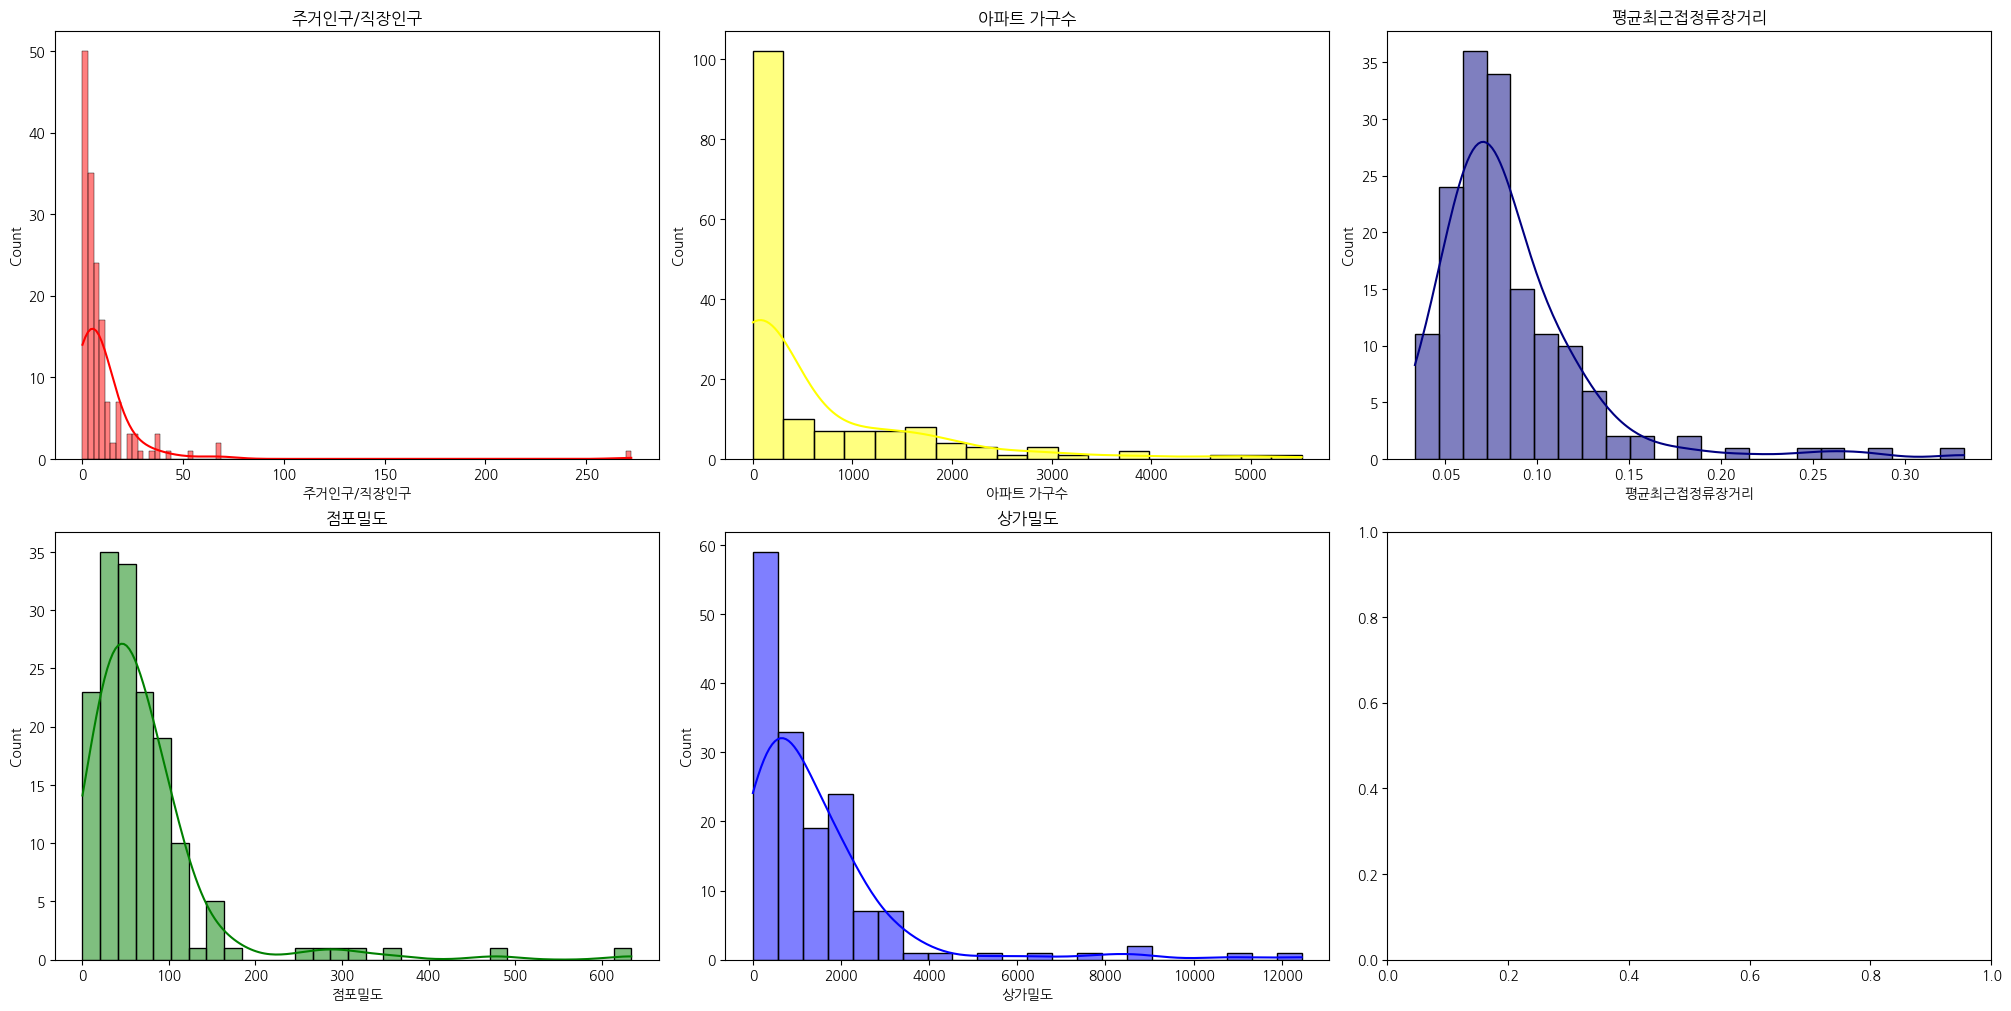

In [140]:
fig, axes = plt.subplots((int(len(skew_col)/3)+1),3,figsize=(20,10),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(int(len(skew_col)/3)+1):
    for j in range(3):
        if (3*i+j) == len(skew_col):
            break
        
        sns.histplot(ax=axes[i,j], data=dX, x=skew_col[(3*i+j)], kde=True,color=color[(3*i+j) % 8])
        axes[i,j].set_title(skew_col[3*i+j])
         
plt.show()

In [148]:
# 해당 컬럼들은 log변환 진행.

# skew = 2, kurtosis=3

scaled_dX = ind_var.loc[:,optimal_feature].copy()
scaled_dX.loc[:,skew_col] = scaled_dX.loc[:,skew_col].apply(lambda x : np.log1p(x))
# scaled_dX.loc[:,robust_ok_col] = RobustScaler().fit_transform(scaled_dX.loc[:,robust_ok_col])

In [149]:
scaled_skew = []

for i, col in enumerate(list(skew_col)):
#     print('{0}. {1} : {2:.3f}'.format(i+1,col,skew(dX.loc[:,col])))
    scaled_skew.append(skew(scaled_dX.loc[:,col]))
#     kurtosis_val.append(kurtosis(dX.loc[:,col],fisher=True))

scaled_skew_data = pd.DataFrame({'column name': skew_col,'skew':scaled_skew})

display(skew_data[skew_data['column name'].isin(skew_col)])
display(scaled_skew_data)

,column name,skew
0,주거인구/직장인구,8.795409
1,아파트 가구수,2.311399
11,평균최근접정류장거리,2.733169
12,점포밀도,3.966894
14,상가밀도,3.401917


,column name,skew
0,주거인구/직장인구,0.279560
1,아파트 가구수,0.015760
2,평균최근접정류장거리,2.479702
3,점포밀도,-0.754883
4,상가밀도,-1.174119


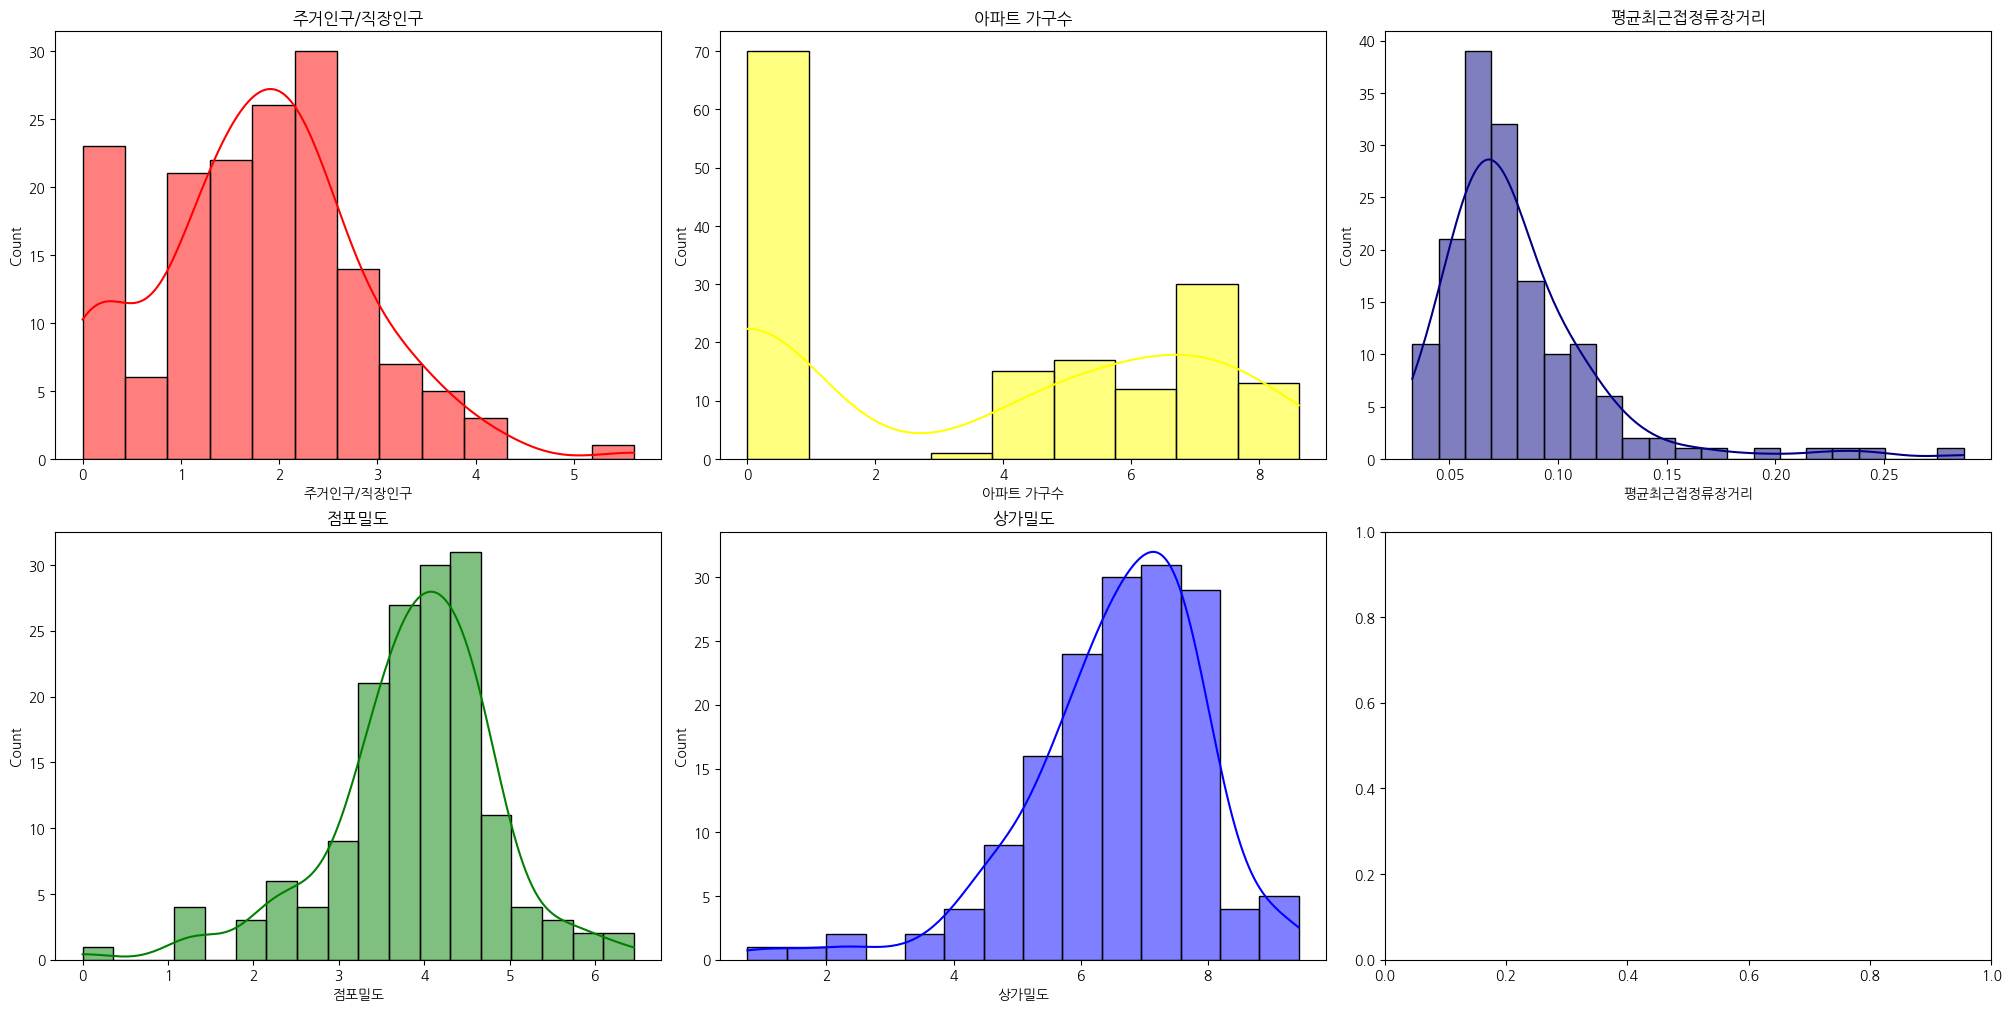

In [150]:
fig, axes = plt.subplots((int(len(skew_col)/3)+1),3,figsize=(20,10),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(int(len(skew_col)/3)+1):
    for j in range(3):
        if (3*i+j) == len(skew_col):
            break
        
        sns.histplot(ax=axes[i,j], data=scaled_dX, x=skew_col[(3*i+j)], kde=True,color=color[(3*i+j) % 8])
        axes[i,j].set_title(skew_col[3*i+j])
        
plt.show()

#### 5.2.2.2 Remodeling

In [151]:
# 스케일링된 독립변수 설정.
s_X = scaled_dX.values

# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel='f2',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel='f2',spherical=True)
gwr_results = gwr_model.fit()

157.0


In [152]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         105928.060
Log-likelihood:                                                    -738.318
AIC:                                                               1508.636
AICc:                                                              1515.007
BIC:                                                             105209.172
R2:                                                                   0.331
Adj. R2:                                                              0.260

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

#### 5.2.2.3 MinMaxScaling
- 교차검증 시 안했을 때의 best score와 같았음.

In [153]:
scaler = MinMaxScaler()
mm_scaled_dX = scaled_dX.copy()
mm_scaled_dX = pd.DataFrame(scaler.fit_transform(mm_scaled_dX),columns=mm_scaled_dX.columns)
s_X = mm_scaled_dX.values

#### 5.2.2.4 Remodeling

In [154]:
# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel='f2',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel='f2',spherical=True)
gwr_results = gwr_model.fit()

157.0


In [155]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         105928.060
Log-likelihood:                                                    -738.318
AIC:                                                               1508.636
AICc:                                                              1515.007
BIC:                                                             105209.172
R2:                                                                   0.331
Adj. R2:                                                              0.260

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

#### 5.2.2.5 Standard Scaling

In [156]:
scaler = StandardScaler()
ss_scaled_dX = scaled_dX.copy()
ss_scaled_dX = pd.DataFrame(scaler.fit_transform(ss_scaled_dX),columns=ss_scaled_dX.columns)
s_X = ss_scaled_dX.values

In [157]:
# 스케일링 후 다중공선성 제거

vif_result = RFE(ss_scaled_dX)
scaled_optimal_feature = vif_result['features'].values.tolist()
scaled_optimal_feature

['서비스업매출비율',
 '외식업매출비율',
 '도로길이고려_전체통합도',
 '평균최근접역거리',
 '평균 도로 길이',
 '평균최근접정류장거리',
 '근린생활시설 비율',
 '단독주택 비율',
 '(주거인구+직장인구) / 유동인구',
 '아파트 가구수',
 '도로율',
 '주거인구/직장인구',
 '공동주택 비율',
 '점포밀도',
 '상가밀도']

#### 5.2.2.6 Remodeling

In [158]:
# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel='f2',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel='f2',spherical=True)
gwr_results = gwr_model.fit()

157.0


In [159]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         105928.060
Log-likelihood:                                                    -738.318
AIC:                                                               1508.636
AICc:                                                              1515.007
BIC:                                                             105209.172
R2:                                                                   0.331
Adj. R2:                                                              0.260

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5.2.3 교차검증

In [160]:
def cross_validation_gwr(lX, ly, kernel,ran_state):
    train_aic = np.zeros(5)
    train_ll = np.zeros(5)
    train_r2 = np.zeros(5)
    train_adj_r2 = np.zeros(5)
    residual = []

    cv = KFold(5, shuffle=True, random_state=ran_state)

    for i, (idx_train, idx_test) in enumerate(cv.split(X = lX, y = ly)):
    
#         print('====================== FOLD {} ======================'.format(i))
        # train, test split
        local_res = np.zeros(158)
        local_X_train, local_y_train = lX[idx_train], ly[idx_train]
        local_u_train = clean_data.iloc[idx_train]['x']
        local_v_train = clean_data.iloc[idx_train]['y']
        local_train_coords = list(zip(local_u_train,local_v_train))
    
        local_X_test, local_y_test = lX[idx_test], ly[idx_test]
        local_u_test = clean_data.iloc[idx_test]['x']
        local_v_test = clean_data.iloc[idx_test]['y']
        local_test_coords = list(zip(local_u_test,local_v_test))
    
        # 모델 생성
        gwr_selector = Sel_BW(local_train_coords, local_y_train, local_X_train,kernel=kernel,spherical=True)
        gwr_bw = gwr_selector.search(bw_min=2)
#         print('BAND WIDTH : {}'.format(gwr_bw))
        gwr_model = GWR(local_train_coords, local_y_train, local_X_train, gwr_bw,kernel=kernel,spherical=True)
        gwr_results = gwr_model.fit()
        
        # Prediction
        scale = gwr_results.scale
        residuals = gwr_results.resid_response
        pred_results = gwr_model.predict(np.array(local_test_coords), local_X_test, scale, residuals)
        pred = pred_results.predictions.flatten()
        
        # AIC
        train_aic[i] = gwr_results.aic
    
        # R2 스코어
        train_r2[i] = gwr_results.R2
        
        # Adj. R2 스코어
        train_adj_r2[i] = gwr_results.adj_R2
#         test_r2[i] = r2_score(local_y_test,pred)
        
        # Log-Likelihood
        train_ll[i] = gwr_results.llf
#         residual.append(local_y_test.flatten()-pred)
#         train_rmse[i] = np.sqrt(gwr_results.)
#         test_rmse[i] = np.sqrt(mean_squared_error(local_y_test,pred))
    
#         print('TRAIN R2 : {:.8f}, TEST R2 : {:.8f}'.format(train_r2[i], test_r2[i]))
# #         print('TRAIN RMSE : {:.8f}, TEST RMSE : {:.8f}'.format(train_rmse[i], test_rmse[i]))
#         print("TRAIN AIC : {:.8f}".format(train_aic[i]))
#         print("TRAIN LOG-LIKELIHOOD : {:.8f}".format(train_ll[i]))
    
#     print('\n===================== 평균 결과 ======================')
#     print('TRAIN R2 : {:.8f}, TEST R2 : {:.8f}'.format(train_r2.mean(), test_r2.mean()))
# #     print('TRAIN RMSE : {:.8f}, TEST RMSE : {:.8f}'.format(train_rmse.mean(), test_rmse.mean()))
#     print("TRAIN AIC : {:.8f}".format(train_aic.mean()))
#     print("TRAIN LOG-LIKELIHOOD : {:.8f}".format(train_ll.mean()))
    
    return train_aic.mean(), train_ll.mean(), train_r2.mean(), train_adj_r2.mean()
# , residual

# cross_validation_gwr(s_X, s_y1)

### 5.2.4 Feature Selection

In [164]:
def search_best_model(kernel,ind_val,ran_state,i):
    flag = True
    min_aic = float('inf')
    max_ll = float('-inf')
    max_r2 = float('-inf')
    adj_r2 = ''
    col_list = list(ind_val.columns)
    drop_col = []

    # flag가 False라면 탈출
    while flag :  
        # 조건 초기화, 평가 치표가 업데이트 된 흔적이 있으면 다시 진입할 것이다.
        flag = False 
    
        # 사용 컬럼 업데이트
#         print('COL LIST COUNT : {}'.format(len(col_list)-len(drop_col)))
#         print('DROP COLUMN LIST COUNT : {}'.format(len(drop_col)))
        col_list = list(set(col_list) - set(drop_col))
        drop_col.clear()
    
        # 사용할 독립변수 업데이트
        temp_dX = ind_val.loc[:,col_list]
    
        # 컬럼 하나씩 지우면서 평가지표 확인
#         for col in tqdm(col_list):
        for col in col_list:
            local_X = temp_dX.drop(col,axis=1).values
            new_aic, new_ll, new_r2, new_adj_r2 = cross_validation_gwr(local_X, s_y1,kernel,ran_state)

            # 새로운 aic는 기존의 aic보다 작고, 새로운 ll은 기존의 ll보다 큰가?(AND 조건이어야 함.)
            if (new_aic < min_aic) & (new_ll > max_ll) & (max_r2 < new_r2):
                min_aic = new_aic
                max_ll = new_ll
                max_r2 = new_r2
                adj_r2 = new_adj_r2
                drop_col.append(col)
                flag = True
                print('========================= NEW VALIDATION =========================')
                print('NEW MAX R2 : {:.8f}'.format(max_r2))
                print('NEW MIN AIC : {:.8f}'.format(min_aic))
                print('NEW MAX LOG-LIKELIHOOD : {:.8f}'.format(max_ll))
    
    print('========================= RESULT =========================')
    print('KERNEL : {}'.format(kernel))
    print('RANDOM STATE : {}'.format(ran_state))
    print('DATASET NUMBER : {}'.format(i))
    print('MAX R2 : {:.8f}'.format(max_r2))
    print('Adj. R2 : {:.8f}'.format(adj_r2))
    print('MIN AIC : {:.8f}'.format(min_aic))
    print('MAX LOG-LIKELIHOOD : {:.8f}'.format(max_ll))
    print('COLUMN COUNT : {}'.format(len(col_list)))
#     print('COLUMN : {}'.format(col_list))

    
    result = pd.DataFrame({'KERNEL':kernel,'RANDOM STATE':ran_state,'DATASET NUMBER':i,'R2':max_r2
                           ,'Adj. R2':adj_r2,'AIC':min_aic,'LOG LIKELIHOOD':max_ll
                           ,'COLUMN COUNT':len(col_list),'COLUMN':[col_list]})
    
    return result

### 5.2.5 Optimal Bandwidth

In [ ]:
store_path = '../data/전처리 파일/가중치행렬(gaussian)'
bandwidth = []
aicc = []
r2 = []
ll = []
start = 20
end = 50
step = 2

for bw in range(start,end,step):
    gwr_bw = bw
    gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel='gaussian',spherical=True)
    gwr_results = gwr_model.fit()
    print('='*30+' RESULT '+'='*30)
    print('Bandwidth : {}, R2 : {:3f}, Log-Likelihood : {:3f}, AICc : {:.3f}'.format(bw,gwr_results.R2,
                                                                              gwr_results.llf,gwr_results.aicc))
    bandwidth.append(bw)
    aicc.append(gwr_results.aicc)
    r2.append(gwr_results.R2)
    ll.append(gwr_results.llf)
#     p_val = spatial_variability(gwr_model,bw,n_iters=1000)
#     print('유의 확률 30% : {}'.format(len(p_val[p_val < 0.3])))
    
#     gwr_coef_df = pd.DataFrame(gwr_results.params)
#     gwr_coef_df.columns = ['intercept']+list(clean_data.iloc[:,ind_var_col].columns)
#     gwr_coef_df['x'] = u
#     gwr_coef_df['y'] = v
#     gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
#     gwr_coef_df.to_csv('../data/전처리 파일/회귀계수/BW별 회귀계수(AICc)/GWR 회귀계수(평균영업기간,bw_'+str(bw)+',1111).csv',index=False,encoding='euc-kr')
    weight = pd.DataFrame(gwr_results.W,columns=clean_data['BAS_ID'],index=clean_data['BAS_ID'])
    weight.to_csv(os.path.join(store_path,'weight('+str(bw)+',gaussian,20_50).csv'),encoding='euc-kr')

aicc_by_bw = pd.DataFrame({'band width':bandwidth,'R2':r2,'Log-Likelihood':ll,'AICc':aicc})

In [ ]:
# Band width에 따른 AICc 그래프
sns.scatterplot(x=aicc_by_bw['band width'],y=aicc_by_bw['AICc'],color='magenta')
plt.show()

In [ ]:
diff_aicc = pd.DataFrame({'Interval':range(0,len(aicc_by_bw['AICc'])-1),'diff':abs(np.diff(aicc_by_bw['AICc']))})

In [ ]:
# AICc 감소폭 그래프

sns.scatterplot(x=diff_aicc['Interval'],y=diff_aicc['diff'],color='violet')
plt.show()

### 5.2.6 Column별 회귀계수 분포

In [174]:
coef_df_list = [] # bw별 회귀계수 data frame list, tuple로 저장할것(bandwidth, coef_df)
coef_df_by_col_list = [] # column별 회귀계수 dataframe list
start = 80
end = 130
step = 2

# bw별로 회귀계수 dataframe 생성
for bw in range(start,end,step):
    gwr_bw = bw
    gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel='bisquare',spherical=True)
    gwr_results = gwr_model.fit()
    gwr_coef_df = pd.DataFrame(gwr_results.params)
    gwr_coef_df.columns = ['intercept']+optimal_feature
    gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
    coef_df_list.append(tuple((bw,gwr_coef_df)))

# column별 회귀계수 dataframe list 생성
for i in range(len(optimal_feature)):
    coef_df_by_col_list.append(pd.DataFrame(columns=range(start,end,step),index=clean_data['BAS_ID']))

# loop 돌면서 각 컬럼별, bw별 dataframe을 생성
for bw,coef_df in coef_df_list:
    for i in range(len(optimal_feature)):
        coef_df_by_col_list[i].loc[:,bw] = coef_df.iloc[:,i].values

In [177]:
len(coef_df_by_col_list)

15

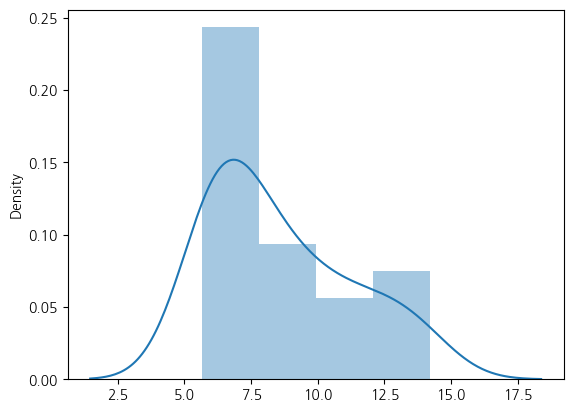

In [179]:
# 개별공시지가 회귀계수의 분포를 살펴보자
col_name = '단독주택 비율'
col_idx = optimal_feature.index(col_name)
target = coef_df_by_col_list[col_idx]
bas_id = '21300'
# target.loc[bas_id].describe()
sns.distplot(x=target.loc[bas_id])
plt.show()

In [ ]:
bas_id_list = list(clean_data['BAS_ID'])
store_path = '../data/전처리 파일/회귀계수/Column별'

for col in tqdm(list(dX)): 
    if '/' in col:
        col_path = col.replace('/',',')
    else:
        col_path = col
        
    if not os.path.isdir(os.path.join(store_path,col_path)):
        os.mkdir(os.path.join(store_path,col_path))
    
    col_idx = dX.columns.values.tolist().index(col)+1
    target = coef_df_by_col_list[col_idx]
    
    for bas_id in bas_id_list:
        # min값과 max값의 부호가 다른 경우에만 그래프 저장 실행
        if (target.loc[bas_id].min()*target.loc[bas_id].max()) > 0:
            continue
            
        sns.histplot(x=target.loc[bas_id], kde=True,color='violet')
        plt.title(bas_id)
        plt.savefig(os.path.join(store_path,col_path,bas_id+'.png'))
        plt.cla()

In [ ]:
dir_list = os.listdir(store_path)
count = []
for dir_name in dir_list:
    file_num = len(os.listdir(os.path.join(store_path,dir_name)))
    count.append(file_num)
#     print('{} : {}'.format(dir_name,file_num))
    
count_df = pd.Series(count,index=dir_list)
count_df.sort_values(ascending=False)

## 5.3 Dataset별 GWR Modeling

In [ ]:
# 1. Raw Data
rd_X = clean_data.iloc[:,ind_var_col]

# 2. Raw Data에서 다중공선성 제거
remove_high_vif_X = clean_data.loc[:,optimal_feature]

# 3. skew가 2 이상인 데이터에 대해서 log1p를 적용한 데이터셋+standard scaler
scaled_X = ss_scaled_dX

# 4. skew가 2 이상인 데이터에 대해서 log1p를 적용하고 다중공선성을 제거한 데이터셋
remove_high_vif_scaled_X = ss_scaled_dX.loc[:,scaled_optimal_feature]

# # 5. Raw Data에서 매출월평균변화량만 제거
# rm_avg_X = clean_data.iloc[:,ind_var_col].drop(['서비스업매출월평균변화량','소매업매출월평균변화량','외식업매출월평균변화량'],axis=1)

# # 6.skew가 2 이상인 데이터에 대해서 log1p를 적용하고 +standard~ 매출월평균변화량만 제거
# scaled_rm_avg_X = ss_scaled_dX.drop(['서비스업매출월평균변화량','소매업매출월평균변화량','외식업매출월평균변화량'],axis=1)

ind_dataset = [rd_X,remove_high_vif_X,scaled_X,remove_high_vif_scaled_X]
kernel = ['gaussian','exponential','bisquare']

aic = []
ll = []
r2 = []
adj_r2 = []
ker = []
dataset_idx = []

for func in kernel:
    for i,s_X in enumerate(ind_dataset):
        s_X = s_X.values
        # 모델 생성
        gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel=func,spherical=True)
        gwr_bw = gwr_selector.search(bw_min=2)
        gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel=func,spherical=True)
        gwr_results = gwr_model.fit()
    
        # 평가 지표
        aic.append(gwr_results.aic)
        ll.append(gwr_results.llf)
        r2.append(gwr_results.R2)
        adj_r2.append(gwr_results.adj_R2)
        ker.append(func)
        dataset_idx.append(i)

valid_result = pd.DataFrame({'Data Number':dataset_idx,'Kernel':ker,'R2':r2,'Adj. R2':adj_r2
                             ,'AIC':aic,'Log-Likelihood':ll})

In [ ]:
valid_result.sort_values(by='Adj. R2',ascending=False)

### 5.3.1 Feature Selection

In [166]:
import time

list_df = [ind_var.loc[:,optimal_feature]]
kernel = ['f2','bisquare']
random_state = [10]

conclusion = pd.DataFrame()
count = 0
start_time = time.time()

for k in kernel:
    for i, df in enumerate(list_df):
        for rs in random_state:
            result = search_best_model(k,df,rs,i)
            conclusion= pd.concat([conclusion,result],axis=0,ignore_index=True)
            count += 1
            print('진행률 : {0:.2f}%, 소요시간 : {1:.2f}분'.format(count/(len(kernel)*len(list_df)*len(random_state))*100,(time.time()-start_time)/60))

conclusion.head()

========================= NEW VALIDATION =========================
NEW MAX R2 : 0.41670513
NEW MIN AIC : 1207.63935229
NEW MAX LOG-LIKELIHOOD : -581.48927697
========================= NEW VALIDATION =========================
NEW MAX R2 : 0.42682470
NEW MIN AIC : 1205.43185205
NEW MAX LOG-LIKELIHOOD : -580.35872232
========================= NEW VALIDATION =========================
NEW MAX R2 : 0.42822691
NEW MIN AIC : 1204.86217069
NEW MAX LOG-LIKELIHOOD : -580.20661249
========================= RESULT =========================
KERNEL : f2
RANDOM STATE : 10
DATASET NUMBER : 0
MAX R2 : 0.42822691
Adj. R2 : 0.31185107
MIN AIC : 1204.86217069
MAX LOG-LIKELIHOOD : -580.20661249
COLUMN COUNT : 12
진행률 : 50.00%, 소요시간 : 0.26분
========================= NEW VALIDATION =========================
NEW MAX R2 : 0.51264096
NEW MIN AIC : 1207.70603743
NEW MAX LOG-LIKELIHOOD : -570.17398940
========================= NEW VALIDATION =========================
NEW MAX R2 : 0.51757971
NEW MIN AIC : 1206.90789

,KERNEL,RANDOM STATE,DATASET NUMBER,R2,Adj. R2,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
0,f2,10,0,0.428227,0.311851,1204.862171,-580.206612,12,"[외식업매출비율, 단독주택 비율, 평균최근접역거리, (주거인구+직장인구) / 유동인..."
1,bisquare,10,0,0.519348,0.350649,1205.682238,-569.291532,12,"[외식업매출비율, 단독주택 비율, 평균최근접역거리, (주거인구+직장인구) / 유동인..."


In [167]:
condition = ((conclusion['AIC'].min() == conclusion['AIC']) | (conclusion['LOG LIKELIHOOD'].max() == conclusion['LOG LIKELIHOOD']) 
             | (conclusion['R2'] == conclusion['R2'].max()))
conclusion[condition]

,KERNEL,RANDOM STATE,DATASET NUMBER,R2,Adj. R2,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
0,f2,10,0,0.428227,0.311851,1204.862171,-580.206612,12,"[외식업매출비율, 단독주택 비율, 평균최근접역거리, (주거인구+직장인구) / 유동인..."
1,bisquare,10,0,0.519348,0.350649,1205.682238,-569.291532,12,"[외식업매출비율, 단독주택 비율, 평균최근접역거리, (주거인구+직장인구) / 유동인..."


In [168]:
conclusion.sort_values(by='R2',ascending=False).head()

,KERNEL,RANDOM STATE,DATASET NUMBER,R2,Adj. R2,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
1,bisquare,10,0,0.519348,0.350649,1205.682238,-569.291532,12,"[외식업매출비율, 단독주택 비율, 평균최근접역거리, (주거인구+직장인구) / 유동인..."
0,f2,10,0,0.428227,0.311851,1204.862171,-580.206612,12,"[외식업매출비율, 단독주택 비율, 평균최근접역거리, (주거인구+직장인구) / 유동인..."


In [171]:
conclusion.loc[1,'COLUMN']

['외식업매출비율',
 '단독주택 비율',
 '평균최근접역거리',
 '(주거인구+직장인구) / 유동인구',
 '도로길이고려_전체통합도',
 '아파트 가구수',
 '공동주택 비율',
 '상가밀도',
 '도로율',
 '근린생활시설 비율',
 '평균최근접정류장거리',
 '주거인구/직장인구']

#### 5.3.1.1 Remodeling

In [ ]:
idx = 2
kernel = 'bisquare'
# conclusion.iloc[idx]['KERNEL']
col = conclusion.iloc[idx]['COLUMN']

# s_X = ind_dataset[idx].loc[:,col].values
s_X = ind_dataset[conclusion.iloc[idx]['DATASET NUMBER']].loc[:,col].values

In [ ]:
#Calibrate GWR model
# 평균영업기간

gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel=kernel,spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel=kernel,spherical=True)
gwr_results = gwr_model.fit()

In [ ]:
gwr_results.summary()

In [ ]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+col
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균영업기간(자동차제거,null유지),1108).csv',index=False,encoding='euc-kr')

In [ ]:
conclusion.to_csv('../data/최적모델평가지표(평균영업기간,자동차제거,매출log,null유지,절사평균).csv',encoding='euc-kr',index=False)

## 5.4 Recursive Local Multicollinearity Elimination 

In [ ]:
def coef_RFE(df):
    flag = True
    next_col = list(df.columns)
    
    while flag:
        
        temp_X = df.loc[:,next_col].values
        
        gwr_selector = Sel_BW(s_coords, s_y1, temp_X,kernel='f1',spherical=True)
        gwr_bw = gwr_selector.search(bw_min=2,bw_max=120)
        gwr_model = GWR(s_coords, s_y1, temp_X, gwr_bw,kernel='f1',spherical=True)
        gwr_results = gwr_model.fit()
        
        gwr_coef_df = pd.DataFrame(gwr_results.params)
        gwr_coef_df.columns = ['intercept']+next_col
    
        result = check_vif(gwr_coef_df.iloc[:,1:])

        if len(result[result['VIF Factor'] > 10]) == 0:
            return gwr_results, result
            # 유일한 탈출 조건
        
        next_col = result.iloc[:-1,1].values.tolist()
        
result, last_feature = coef_RFE(clean_data.loc[:,optimal_feature])
display(last_feature)
display(result.summary())

In [ ]:
last_feature['features'].values

In [ ]:
cc = result.local_collinearity()[1]
cc.max()

In [ ]:
nrow = len(gwr_results.W)
x = s_X
nvar = x.shape[1]
vdp_idx = np.ndarray((nrow, nvar))
temp_vdp_idx = np.ndarray((nrow, 1))

for i in range(nrow):
    wi = gwr_results.W[i]
    sw = np.sum(wi)
    wi = wi / sw
    
    # 다시 스케일링...?
    xw = x * wi.reshape((nrow, 1))
    sxw = np.sqrt(np.sum(xw**2, axis=0))
    sxw = np.transpose(xw.T / sxw.reshape((nvar, 1)))
    svdx = np.linalg.svd(sxw)
    vdp_idx[i, ] = svdx[1][0] / svdx[1]
    temp_vdp_idx[i,] = np.linalg.cond(sxw)

local_CN = vdp_idx[:, nvar - 1].reshape((-1, 1))

In [ ]:
local_CN[:10]

In [ ]:
temp_vdp_idx[:10]

# 7. T-검정
- 예측값과 실제값의 평균이 서로 차이가 있는지 검정한다.

In [ ]:
# 필요 데이터셋 생성
s_X = pd.concat([dX.loc[:,col],clean_data.loc[:,['x','y']]],axis=1)

# train, test split
X_train, X_test, y_train, y_test = train_test_split(s_X, s_y1, test_size=0.2, shuffle=True,random_state=34)

# train 좌표 생성
u_train = X_train.loc[:,'x']
v_train = X_train.loc[:,'y']
train_coords = list(zip(u_train,v_train))

# test 좌표 생성
u_test = X_test.loc[:,'x']
v_test = X_test.loc[:,'y']
test_coords = list(zip(u_test,v_test))

# train, test set 독립변수 리스트에서 좌표 제거
X_train.drop(['x','y'],axis=1,inplace=True)
X_test.drop(['x','y'],axis=1,inplace=True)

X_train = X_train.values
X_test = X_test.values

# 모델 생성
gwr_selector = Sel_BW(train_coords, y_train, X_train,kernel='gaussian')
gwr_bw = gwr_selector.search(bw_min=2)

print('BAND WIDTH : {}'.format(gwr_bw))
gwr_model = GWR(train_coords, y_train, X_train, gwr_bw,kernel='gaussian')
gwr_results = gwr_model.fit()
    
# Prediction
scale = gwr_results.scale
residuals = gwr_results.resid_response
pred_results = gwr_model.predict(np.array(test_coords), X_test, scale, residuals)
pred = pred_results.predictions.flatten() 

## 7.1 정규성 검증

In [ ]:
test = stats.shapiro(y_test)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 유의 수준 0.05에서 귀무가설을 기각할 수 없으므로 y_test는 정규성을 따른다.

In [ ]:
test = stats.shapiro(pred)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 유의수준 0.05에서 귀무가설을 기각하고 대립가설을 채택
# 따라서 정규성을 띄지 않는다.

In [ ]:
df = pd.DataFrame({'pred':pred,'test':y_test.flatten()})
df.describe()

In [ ]:
# 독립이표본 t-test
result = stats.ttest_ind(pred, y_test, equal_var=False)
print('p-value : {:.8f}'.format(result[1][0]))

# 유의 수준 0.05에서 귀무가설을 기각할 수 없으므로 두 집단 간의 평균 차이가 없다고 말할 수 있다.

In [ ]:
ax = plt.subplot()
sns.distplot(y_test,ax=ax,color='red',label='test set',hist=False)
sns.distplot(pred,ax=ax,color='violet',label='prediction',hist=False)
ax.set_title('Prediction vs Test Set')
ax.legend()
plt.show()